# Chapter 2 - Scaling Laws
## Deep Learning Curriculum - Jacob Hilton

Perform your own study of scaling laws for MNIST.

* Write a script to train a small CNN on MNIST, or find one you have written previously.
* Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.
* The learning rate will need to vary with model size. Either tune it carefully for each model size, or use the rule of thumb that for Adam, the learning rate should be proportional to the initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization (which is what PyTorch generally uses by default).
* Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).
* How does validation accuracy behave?
* Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.
* Repeat your entire experiment with 20% dropout to see how this affects the scaling exponents.

In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# transforms data to tensors [0, 255] range then normalizes
# the data to [-1, 1] range
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
train = MNIST('mnist_data_train.csv', download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15704201.46it/s]


Extracting mnist_data_train.csv/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data_train.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 500668.30it/s]


Extracting mnist_data_train.csv/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data_train.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3815186.40it/s]


Extracting mnist_data_train.csv/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data_train.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8868961.25it/s]

Extracting mnist_data_train.csv/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data_train.csv/MNIST/raw



In [5]:
test = MNIST('mnist_data_test.csv', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16000467.69it/s]


Extracting mnist_data_test.csv/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data_test.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 507699.99it/s]


Extracting mnist_data_test.csv/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data_test.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3816988.85it/s]


Extracting mnist_data_test.csv/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data_test.csv/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7595904.61it/s]

Extracting mnist_data_test.csv/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data_test.csv/MNIST/raw



In [6]:
train[0][0].shape

torch.Size([1, 28, 28])

In [7]:
print('Train Size:', len(train), 'Test Size:', len(test))

Train Size: 60000 Test Size: 10000


In [8]:
# in order to make it easier to tune the train data size
# we will write the following function
from torch.utils.data import DataLoader

def dataset_size_tune(dataset, power):

  assert power % 2 == 0

  if power == 0:
    p = 1
    return DataLoader(dataset, batch_size=64, shuffle=True)
  else:
    p = 1 / power
    np.random.seed(77)
    torch.manual_seed(77)
    gen = torch.Generator().manual_seed(77)
    other, train_d = torch.utils.data.random_split(dataset, [1-p, p], generator=gen)
    train_dlr = DataLoader(train_d, batch_size=64, shuffle=True)

    return train_dlr

In [9]:
# creating dataloaders
train_dlr_full = dataset_size_tune(train, 0)
train_dlr_half = dataset_size_tune(train, 2)
train_dlr_quar = dataset_size_tune(train, 4)
train_dlr_eigh = dataset_size_tune(train, 8)
train_dlr_teen = dataset_size_tune(train, 16)
train_dlr_thir = dataset_size_tune(train, 32)
test_dlr  = DataLoader(test, batch_size=64, shuffle=True)

In [10]:
img, label = next(iter(train_dlr_full))

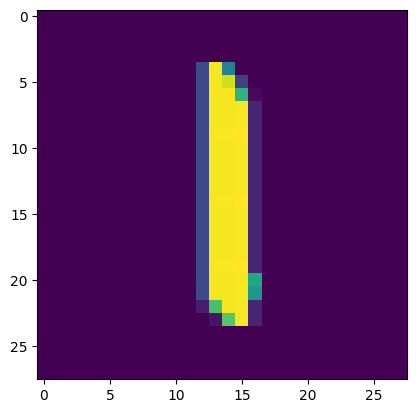

tensor(1)


In [11]:
import matplotlib.pyplot as plt
plt.imshow(img[0].view(28, 28))
plt.show()
print(label[0])

In [12]:
np.unique(label).shape

(10,)

## Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math

In [14]:
class Config:

  def __init__(self,
               ks,
               mp,
               nchan,
               convdepth,
               nhid1,
               nhid2,
               drop):

    assert len(ks) == len(nchan) == convdepth

    self.ks = ks
    self.maxpooling = mp
    self.outchans = nchan
    initial_chan = [1]
    initial_chan.extend(nchan)
    initial_chan.remove(nchan[-1])
    self.inchans = initial_chan
    self.CNNDepth = convdepth
    self.hidden1 = nhid1
    self.hidden2 = nhid2
    self.dropout = drop

In [15]:
class MLP(nn.Module):

  def __init__(self, cfg):
    super(MLP, self).__init__()

    self.depth = cfg.CNNDepth
    dim = self.divBy2()
    self.l1 = nn.Linear(cfg.outchans[-1] * dim * dim, cfg.hidden1)
    self.drop1 = nn.Dropout(cfg.dropout)
    self.l2 = nn.Linear(cfg.hidden1, cfg.hidden2)
    self.drop2 = nn.Dropout(cfg.dropout)
    self.l3 = nn.Linear(cfg.hidden2, 10)

  def divBy2(self, val=28):

    for _ in range(self.depth):

      val /= 2
      val += 1

    return int(math.modf(val)[1])

  def forward(self, X):

    out = self.drop1(F.relu(self.l1(X)))
    out = self.drop2(F.relu(self.l2(out)))
    out = self.l3(out)

    return out

In [16]:
class Convolution(nn.Module):

  def __init__(self, cfg):
    super(Convolution, self).__init__()

    self.CNNDepth = cfg.CNNDepth
    self.layers = nn.ModuleList([nn.Sequential(
        nn.Conv2d(cfg.inchans[i], cfg.outchans[i], cfg.ks[i], padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(cfg.maxpooling, padding=1),
        nn.Dropout(cfg.dropout)) for i in range(self.CNNDepth)])

  def forward(self, img):

    for i, l in enumerate(self.layers):

      img = l(img)

    return img

In [17]:
class CNN(nn.Module):

  def __init__(self, cfg):
    super(CNN, self).__init__()

    self.convs = Convolution(cfg)
    self.mlp = MLP(cfg)

  def forward(self, img):

    conv_out = self.convs(img)
    out = torch.flatten(conv_out, 1)
    out = self.mlp(out)

    return out

In [18]:
# model 1
convdepth1 = 2
ks1 = [3, 3]
nchan1 = [32, 64]
cfg1 = Config(ks=ks1,
              mp=2,
              nchan=nchan1,
              convdepth=convdepth1,
              nhid1=128,
              nhid2=256,
              drop=0)

cnn1 = CNN(cfg1).to(device)

In [19]:
summary(cnn1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
           Dropout-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
              ReLU-6           [-1, 64, 15, 15]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
       Convolution-9             [-1, 64, 8, 8]               0
           Linear-10                  [-1, 128]         524,416
          Dropout-11                  [-1, 128]               0
           Linear-12                  [-1, 256]          33,024
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [20]:
# model 2
convdepth2 = 3
ks2 = [3, 3, 3]
nchan2 = [32, 32, 64]
cfg2 = Config(ks=ks2,
              mp=2,
              nchan=nchan2,
              convdepth=convdepth2,
              nhid1=128,
              nhid2=256,
              drop=0)

cnn2 = CNN(cfg2).to(device)

In [21]:
summary(cnn2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
           Dropout-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 32, 15, 15]           9,248
              ReLU-6           [-1, 32, 15, 15]               0
         MaxPool2d-7             [-1, 32, 8, 8]               0
           Dropout-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
             ReLU-10             [-1, 64, 8, 8]               0
        MaxPool2d-11             [-1, 64, 5, 5]               0
          Dropout-12             [-1, 64, 5, 5]               0
      Convolution-13             [-1, 64, 5, 5]               0
           Linear-14                  [

In [22]:
# model 3
convdepth3 = 4
ks3 = [3, 3, 3, 3]
nchan3 = [32, 32, 64, 128]
cfg3 = Config(ks=ks3,
              mp=2,
              nchan=nchan3,
              convdepth=convdepth3,
              nhid1=128,
              nhid2=256,
              drop=0)

cnn3 = CNN(cfg3).to(device)

In [23]:
summary(cnn3, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
           Dropout-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 32, 15, 15]           9,248
              ReLU-6           [-1, 32, 15, 15]               0
         MaxPool2d-7             [-1, 32, 8, 8]               0
           Dropout-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
             ReLU-10             [-1, 64, 8, 8]               0
        MaxPool2d-11             [-1, 64, 5, 5]               0
          Dropout-12             [-1, 64, 5, 5]               0
           Conv2d-13            [-1, 128, 5, 5]          73,856
             ReLU-14            [-1, 12

### Parameter Counting Function

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
print('CNN1:', count_parameters(cnn1), '\nCNN2:', count_parameters(cnn2), '\nCNN3:', count_parameters(cnn3))

CNN1: 578826 
CNN2: 268586 
CNN3: 285098


### Checking Model Forward Pass

In [26]:
img, label = next(iter(train_dlr_full))

In [27]:
out = cnn1(img.to(device))
print(out.argmax(dim=-1))

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')


In [28]:
out = cnn2(img.to(device))
print(out.argmax(dim=-1))

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5], device='cuda:0')


In [29]:
out = cnn3(img.to(device))
print(out.argmax(dim=-1))

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')


## Training and Evaluation Functions

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
def train(m, dlrt, loss, optm):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  m.to(device)
  m.train()
  train_running_loss = 0
  train_bar = tqdm(enumerate(dlrt), total=len(dlrt))
  accuracy = 0

  for i, (img, label) in train_bar:

    img = img.to(device)
    label = label.to(device)

    # zero the gradient
    optm.zero_grad()

    # forward
    output = m(img)
    # get loss
    l = loss(output, label)

    # backpropagate
    l.backward()

    # step
    optm.step()

    # update running loss
    train_running_loss += l.cpu().item()
    accuracy += accuracy_score(output.argmax(dim=-1).cpu().detach().numpy(), label.cpu().detach().numpy())

  print('Finished Batch: ')
  epoch_loss = train_running_loss / len(dlrt)
  epoch_acc = accuracy / len(dlrt)

  print('Training Loss: ', epoch_loss,
        'Training Av. Accuracy: ', epoch_acc)

  return epoch_loss, epoch_acc

In [32]:
def evaluate(m, dlrt, loss):

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    m.eval()
    val_running_loss = 0
    test_bar = tqdm(enumerate(dlrt), total=len(dlrt))
    accuracy = 0

    for i, (img, label) in test_bar:

      img = img.to(device)
      label = label.to(device)

      # forward
      output = m(img)

      # get loss
      l = loss(output, label)

      # update running loss
      val_running_loss += l.item()
      accuracy += accuracy_score(output.argmax(dim=-1).cpu().detach().numpy(), label.cpu().detach().numpy())

    valid_loss = val_running_loss / len(dlrt)
    valid_acc  = accuracy / len(dlrt)

    print('Validation Loss: ', valid_loss,
          'Validation Av. Accuracy: ', valid_acc)

    return valid_loss, valid_acc

## Dataset Size Effect

In [33]:
import plotly.graph_objects as go
import plotly.express as px

In [34]:
train_dataloaders = [train_dlr_thir, train_dlr_teen, train_dlr_eigh, train_dlr_quar, train_dlr_half, train_dlr_full]
train_dlr_sizes = [len(i.dataset) for i in train_dataloaders]

In [35]:
test_losses = []
test_accuracies = []
train_losses_full = []
lr = 1e-4
max_epochs = 1
loss = nn.CrossEntropyLoss()
n_reps = 5

# run for each dataset size
for i, dlr in enumerate(train_dataloaders):
  running_test_loss = 0
  running_test_acc = 0
  for j in range(n_reps):
    # create model and instantiate optimizer
    cnn = CNN(cfg1)
    optm = torch.optim.Adam(cnn.parameters(), lr=lr)
    train_losses = []
    print(f'########### START DLR {i} REP {j} ###########')
    for e in range(max_epochs):
      train_loss, train_acc = train(cnn, dlr, loss, optm)
      train_losses.append(train_loss)
    print('EVALUATING')
    test_loss, test_acc = evaluate(cnn, test_dlr, loss)
    running_test_loss += test_loss
    running_test_acc += test_acc
    train_losses_full.append(train_losses)
    print(f'############ END DLR {i} REP {j} ############')
    print('\n')
  test_losses.append(running_test_loss/n_reps)
  test_accuracies.append(running_test_acc/n_reps)

########### START DLR 0 REP 0 ###########


100%|██████████| 30/30 [00:01<00:00, 21.08it/s]


Finished Batch: 
Training Loss:  2.2757464090983075 Training Av. Accuracy:  0.1868969298245614
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.24it/s]


Validation Loss:  2.2383904639323045 Validation Av. Accuracy:  0.24213773885350318
############ END DLR 0 REP 0 ############


########### START DLR 0 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 55.08it/s]


Finished Batch: 
Training Loss:  2.2726931015650433 Training Av. Accuracy:  0.2611019736842105
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.67it/s]


Validation Loss:  2.2207729224186794 Validation Av. Accuracy:  0.4876592356687898
############ END DLR 0 REP 1 ############


########### START DLR 0 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 56.06it/s]


Finished Batch: 
Training Loss:  2.265126411120097 Training Av. Accuracy:  0.23878837719298246
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.38it/s]


Validation Loss:  2.1965538544260013 Validation Av. Accuracy:  0.40863853503184716
############ END DLR 0 REP 2 ############


########### START DLR 0 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 54.73it/s]


Finished Batch: 
Training Loss:  2.2719930013020835 Training Av. Accuracy:  0.18930921052631577
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Validation Loss:  2.2234337208377326 Validation Av. Accuracy:  0.2778662420382166
############ END DLR 0 REP 3 ############


########### START DLR 0 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 54.09it/s]


Finished Batch: 
Training Loss:  2.272481989860535 Training Av. Accuracy:  0.23325109649122808
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.75it/s]


Validation Loss:  2.2235924984998765 Validation Av. Accuracy:  0.31329617834394907
############ END DLR 0 REP 4 ############


########### START DLR 1 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 52.76it/s]


Finished Batch: 
Training Loss:  2.1992133734589916 Training Av. Accuracy:  0.2879683318465656
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.61it/s]


Validation Loss:  1.9740044630257187 Validation Av. Accuracy:  0.5022890127388535
############ END DLR 1 REP 0 ############


########### START DLR 1 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 52.20it/s]


Finished Batch: 
Training Loss:  2.1875801106630743 Training Av. Accuracy:  0.35883140053523643
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.95it/s]


Validation Loss:  1.9321882800691446 Validation Av. Accuracy:  0.47900079617834396
############ END DLR 1 REP 1 ############


########### START DLR 1 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 39.47it/s]


Finished Batch: 
Training Loss:  2.2070994296316373 Training Av. Accuracy:  0.3045550847457627
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.78it/s]


Validation Loss:  1.9914849670069992 Validation Av. Accuracy:  0.5423964968152867
############ END DLR 1 REP 2 ############


########### START DLR 1 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 55.03it/s]


Finished Batch: 
Training Loss:  2.2223487385248735 Training Av. Accuracy:  0.28629571810883137
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 68.13it/s]


Validation Loss:  2.023279654751917 Validation Av. Accuracy:  0.5698646496815286
############ END DLR 1 REP 3 ############


########### START DLR 1 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 56.70it/s]


Finished Batch: 
Training Loss:  2.1729888168431946 Training Av. Accuracy:  0.367250223015165
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.03it/s]


Validation Loss:  1.8845656639451434 Validation Av. Accuracy:  0.5759355095541401
############ END DLR 1 REP 4 ############


########### START DLR 2 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 46.63it/s]


Finished Batch: 
Training Loss:  1.7228373976077063 Training Av. Accuracy:  0.5692973163841808
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.84it/s]


Validation Loss:  0.8229797490083488 Validation Av. Accuracy:  0.7756767515923567
############ END DLR 2 REP 0 ############


########### START DLR 2 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 55.33it/s]


Finished Batch: 
Training Loss:  1.8203646853818731 Training Av. Accuracy:  0.5217161016949152
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 68.32it/s]


Validation Loss:  0.9306637621988916 Validation Av. Accuracy:  0.7531847133757962
############ END DLR 2 REP 1 ############


########### START DLR 2 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 54.39it/s]


Finished Batch: 
Training Loss:  1.8604314362598677 Training Av. Accuracy:  0.5297934322033898
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.23it/s]


Validation Loss:  0.967626878410388 Validation Av. Accuracy:  0.7977707006369427
############ END DLR 2 REP 2 ############


########### START DLR 2 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 43.58it/s]


Finished Batch: 
Training Loss:  1.794114155284429 Training Av. Accuracy:  0.5291754943502825
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.63it/s]


Validation Loss:  0.8870290145752536 Validation Av. Accuracy:  0.7734872611464968
############ END DLR 2 REP 3 ############


########### START DLR 2 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 55.10it/s]


Finished Batch: 
Training Loss:  1.8262882667072748 Training Av. Accuracy:  0.46746998587570626
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.96it/s]


Validation Loss:  1.0042580597719568 Validation Av. Accuracy:  0.7628383757961783
############ END DLR 2 REP 4 ############


########### START DLR 3 REP 0 ###########


100%|██████████| 235/235 [00:05<00:00, 45.75it/s]


Finished Batch: 
Training Loss:  1.2431323572676232 Training Av. Accuracy:  0.6504654255319149
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.84it/s]


Validation Loss:  0.4424756459749428 Validation Av. Accuracy:  0.8783837579617835
############ END DLR 3 REP 0 ############


########### START DLR 3 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 55.11it/s]


Finished Batch: 
Training Loss:  1.1937314843877833 Training Av. Accuracy:  0.6925531914893617
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.22it/s]


Validation Loss:  0.4238021756243554 Validation Av. Accuracy:  0.880672770700637
############ END DLR 3 REP 1 ############


########### START DLR 3 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 40.98it/s]


Finished Batch: 
Training Loss:  1.161686788594469 Training Av. Accuracy:  0.6939716312056738
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.42it/s]


Validation Loss:  0.3870816072271128 Validation Av. Accuracy:  0.8976910828025477
############ END DLR 3 REP 2 ############


########### START DLR 3 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 55.88it/s]


Finished Batch: 
Training Loss:  1.2426465800467958 Training Av. Accuracy:  0.643218085106383
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.72it/s]


Validation Loss:  0.4560529212852952 Validation Av. Accuracy:  0.8695262738853503
############ END DLR 3 REP 3 ############


########### START DLR 3 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 54.79it/s]


Finished Batch: 
Training Loss:  1.2049358840952529 Training Av. Accuracy:  0.6549867021276595
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.94it/s]


Validation Loss:  0.42765723652900406 Validation Av. Accuracy:  0.8830613057324841
############ END DLR 3 REP 4 ############


########### START DLR 4 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 50.56it/s]


Finished Batch: 
Training Loss:  0.7953579775623675 Training Av. Accuracy:  0.7834377221037669
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.88it/s]


Validation Loss:  0.28803988930526053 Validation Av. Accuracy:  0.9164012738853503
############ END DLR 4 REP 0 ############


########### START DLR 4 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 50.10it/s]


Finished Batch: 
Training Loss:  0.8154829102856264 Training Av. Accuracy:  0.7885683191186923
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.43it/s]


Validation Loss:  0.28052964517075546 Validation Av. Accuracy:  0.9173964968152867
############ END DLR 4 REP 1 ############


########### START DLR 4 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 49.78it/s]


Finished Batch: 
Training Loss:  0.851338768437473 Training Av. Accuracy:  0.7604055614783226
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.51it/s]


Validation Loss:  0.297174322756992 Validation Av. Accuracy:  0.9161027070063694
############ END DLR 4 REP 2 ############


########### START DLR 4 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 50.26it/s]


Finished Batch: 
Training Loss:  0.7671248485157485 Training Av. Accuracy:  0.7904117803837953
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.14it/s]


Validation Loss:  0.27604979941040086 Validation Av. Accuracy:  0.9188893312101911
############ END DLR 4 REP 3 ############


########### START DLR 4 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 52.80it/s]


Finished Batch: 
Training Loss:  0.7553447968542957 Training Av. Accuracy:  0.8052149964463396
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.74it/s]


Validation Loss:  0.25876611732183746 Validation Av. Accuracy:  0.923765923566879
############ END DLR 4 REP 4 ############


########### START DLR 5 REP 0 ###########


100%|██████████| 938/938 [00:17<00:00, 53.39it/s]


Finished Batch: 
Training Loss:  0.45199243995601307 Training Av. Accuracy:  0.8777818496801706
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.55it/s]


Validation Loss:  0.1380880301592836 Validation Av. Accuracy:  0.956906847133758
############ END DLR 5 REP 0 ############


########### START DLR 5 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 50.80it/s]


Finished Batch: 
Training Loss:  0.4946807243628924 Training Av. Accuracy:  0.8657216151385928
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.27it/s]


Validation Loss:  0.15257740514293597 Validation Av. Accuracy:  0.9541202229299363
############ END DLR 5 REP 1 ############


########### START DLR 5 REP 2 ###########


100%|██████████| 938/938 [00:24<00:00, 38.96it/s]


Finished Batch: 
Training Loss:  0.49565402248393753 Training Av. Accuracy:  0.8619902718550106
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 68.44it/s]


Validation Loss:  0.15134021058488803 Validation Av. Accuracy:  0.955015923566879
############ END DLR 5 REP 2 ############


########### START DLR 5 REP 3 ###########


100%|██████████| 938/938 [00:17<00:00, 52.42it/s]


Finished Batch: 
Training Loss:  0.5043263621072271 Training Av. Accuracy:  0.8587919776119403
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.71it/s]


Validation Loss:  0.1533570042840994 Validation Av. Accuracy:  0.95421974522293
############ END DLR 5 REP 3 ############


########### START DLR 5 REP 4 ###########


100%|██████████| 938/938 [00:17<00:00, 52.94it/s]


Finished Batch: 
Training Loss:  0.5298234012398892 Training Av. Accuracy:  0.8442830490405118
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.90it/s]

Validation Loss:  0.17970264408808606 Validation Av. Accuracy:  0.948546974522293
############ END DLR 5 REP 4 ############




In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_losses, name='Test Loss'))
fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_accuracies, name='Test Accuracy'))
fig.update_layout(title='Dataset Size Effect on Test Loss',
                  yaxis_title='Loss',
                  xaxis_title='Size')
fig.show()

In [37]:
fig = px.scatter(x=train_dlr_sizes, y=np.log(test_losses), title='Datasize Effect on Log Test Losses', trendline='ols')
fig.show()

## Model Size Effect

We will first change model width only. We will later check if depth really has no effect keeping model size constant.

We will adapt the learning rate following what is described in the Appendix of the article:

$LR(N) ≈ 0.003239 + −0.0001395 log(N) $

In [47]:
test_losses_NandD = {k:[] for k in range(len(train_dataloaders))}
test_acc_NandD = {k:[] for k in range(len(train_dataloaders))}
N_params = []

In [49]:
# training
max_epochs = 1
loss = nn.CrossEntropyLoss()
n_models = 6
n_reps = 5

# run for each dataset size
for i, dlr in enumerate(train_dataloaders):

  # arch
  convdepth = 2
  ks = [3, 3]
  nchan = [4, 4]
  nhid1 = 32
  nhid2 = 32

  for j in range(n_models):
    running_test_loss = 0
    running_test_acc = 0
    for r in range(n_reps):
      # create configs
      cfg = Config(ks=ks,
                  mp=2,
                  nchan=nchan,
                  convdepth=convdepth,
                  nhid1=nhid1,
                  nhid2=nhid2,
                  drop=0)

      # create model and instantiate optimizer
      cnn = CNN(cfg)
      N = count_parameters(cnn)
      N_params.append(N)
      lr = 0.003239  + ((-0.0001395) * np.log(N))
      print('MODEL', j, 'PARAMETER COUNT:', N)
      optm = torch.optim.Adam(cnn.parameters(), lr=lr)
      # train and evaluate
      print(f'########### START DLR {i} MODEL {j} REP {r} ###########')
      for e in range(max_epochs):
        train_loss, train_acc = train(cnn, dlr, loss, optm)
        train_losses.append(train_loss)
      print('EVALUATING')
      test_loss, test_acc = evaluate(cnn, test_dlr, loss)
      running_test_loss += test_loss
      running_test_acc += test_acc
      print(f'############ END DLR {i} MODEL {j} REP {r} ############')
      print('\n')

    test_losses_NandD[i].append(running_test_loss/n_reps)
    test_acc_NandD[i].append(running_test_acc/n_reps)

    # change arch params
    nchan = [round(np.sqrt(2)*m) for m in nchan]
    nhid1 = round(np.sqrt(2)*nhid1)
    nhid2 = round(np.sqrt(2)*nhid2)

MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 30.97it/s]


Finished Batch: 
Training Loss:  2.2486424605051676 Training Av. Accuracy:  0.14588815789473683
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


Validation Loss:  2.048972427465354 Validation Av. Accuracy:  0.35698646496815284
############ END DLR 0 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 59.33it/s]


Finished Batch: 
Training Loss:  2.2652862230936686 Training Av. Accuracy:  0.18467653508771928
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


Validation Loss:  2.1470519008150526 Validation Av. Accuracy:  0.4112261146496815
############ END DLR 0 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 59.78it/s]


Finished Batch: 
Training Loss:  2.2564424514770507 Training Av. Accuracy:  0.22634320175438596
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.92it/s]


Validation Loss:  2.126102556848222 Validation Av. Accuracy:  0.35171178343949044
############ END DLR 0 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 36.67it/s]


Finished Batch: 
Training Loss:  2.231990667184194 Training Av. Accuracy:  0.17752192982456141
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.04it/s]


Validation Loss:  1.9624991128399114 Validation Av. Accuracy:  0.4115246815286624
############ END DLR 0 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 59.13it/s]


Finished Batch: 
Training Loss:  2.2744004487991334 Training Av. Accuracy:  0.1831688596491228
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.39it/s]


Validation Loss:  2.175693800494929 Validation Av. Accuracy:  0.283140923566879
############ END DLR 0 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 60.94it/s]


Finished Batch: 
Training Loss:  2.2972312211990356 Training Av. Accuracy:  0.11809210526315789
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.60it/s]


Validation Loss:  2.2794861656844994 Validation Av. Accuracy:  0.10300557324840764
############ END DLR 0 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 60.77it/s]


Finished Batch: 
Training Loss:  2.2078160961469013 Training Av. Accuracy:  0.24276315789473685
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.98it/s]


Validation Loss:  1.9101973377215635 Validation Av. Accuracy:  0.43710191082802546
############ END DLR 0 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 37.01it/s]


Finished Batch: 
Training Loss:  2.1615166227022806 Training Av. Accuracy:  0.32738486842105263
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.16it/s]


Validation Loss:  1.7528632871664254 Validation Av. Accuracy:  0.5029856687898089
############ END DLR 0 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 53.44it/s]


Finished Batch: 
Training Loss:  2.215068014462789 Training Av. Accuracy:  0.21513157894736842
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.52it/s]


Validation Loss:  1.9350849131869663 Validation Av. Accuracy:  0.3756966560509554
############ END DLR 0 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 58.69it/s]


Finished Batch: 
Training Loss:  2.265089686711629 Training Av. Accuracy:  0.20641447368421054
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.21it/s]


Validation Loss:  2.1398216812473954 Validation Av. Accuracy:  0.3088176751592357
############ END DLR 0 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 56.13it/s]


Finished Batch: 
Training Loss:  2.2636603832244875 Training Av. Accuracy:  0.19797149122807017
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.23it/s]


Validation Loss:  2.1217051812797596 Validation Av. Accuracy:  0.34454617834394907
############ END DLR 0 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 35.21it/s]


Finished Batch: 
Training Loss:  2.2633565584818522 Training Av. Accuracy:  0.20921052631578946
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.62it/s]


Validation Loss:  2.1275222286297257 Validation Av. Accuracy:  0.31339570063694266
############ END DLR 0 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 58.27it/s]


Finished Batch: 
Training Loss:  2.1768762667973838 Training Av. Accuracy:  0.22439692982456141
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.84it/s]


Validation Loss:  1.808535524993945 Validation Av. Accuracy:  0.4434713375796178
############ END DLR 0 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 60.07it/s]


Finished Batch: 
Training Loss:  2.201698537667592 Training Av. Accuracy:  0.2409813596491228
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.29it/s]


Validation Loss:  1.8744803439280031 Validation Av. Accuracy:  0.43451433121019106
############ END DLR 0 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 60.05it/s]


Finished Batch: 
Training Loss:  1.9928681254386902 Training Av. Accuracy:  0.3894188596491228
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.06it/s]


Validation Loss:  1.359550329530315 Validation Av. Accuracy:  0.5723527070063694
############ END DLR 0 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 36.90it/s]


Finished Batch: 
Training Loss:  2.1701858560244243 Training Av. Accuracy:  0.23116776315789475
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.06it/s]


Validation Loss:  1.7256215863926396 Validation Av. Accuracy:  0.429140127388535
############ END DLR 0 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 61.96it/s]


Finished Batch: 
Training Loss:  1.8774151086807251 Training Av. Accuracy:  0.40646929824561406
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.57it/s]


Validation Loss:  1.0944310616535746 Validation Av. Accuracy:  0.6641122611464968
############ END DLR 0 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 55.55it/s]


Finished Batch: 
Training Loss:  2.057010793685913 Training Av. Accuracy:  0.3103892543859649
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.15it/s]


Validation Loss:  1.3390935629036775 Validation Av. Accuracy:  0.6290804140127388
############ END DLR 0 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 59.67it/s]


Finished Batch: 
Training Loss:  2.123041299978892 Training Av. Accuracy:  0.2478892543859649
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.34it/s]


Validation Loss:  1.5496057826242629 Validation Av. Accuracy:  0.5304538216560509
############ END DLR 0 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 34.20it/s]


Finished Batch: 
Training Loss:  1.7443491419156392 Training Av. Accuracy:  0.4794407894736842
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.83it/s]


Validation Loss:  0.8593821933694706 Validation Av. Accuracy:  0.7306926751592356
############ END DLR 0 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 55.56it/s]


Finished Batch: 
Training Loss:  1.8516721407572427 Training Av. Accuracy:  0.4201480263157895
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.47it/s]


Validation Loss:  0.8666395396943305 Validation Av. Accuracy:  0.7614450636942676
############ END DLR 0 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 55.83it/s]


Finished Batch: 
Training Loss:  1.9365948597590128 Training Av. Accuracy:  0.3374451754385965
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.68it/s]


Validation Loss:  1.1227611656401568 Validation Av. Accuracy:  0.6712778662420382
############ END DLR 0 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 57.37it/s]


Finished Batch: 
Training Loss:  1.6718620757261913 Training Av. Accuracy:  0.47689144736842104
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.12it/s]


Validation Loss:  0.950880322866379 Validation Av. Accuracy:  0.6760549363057324
############ END DLR 0 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 35.03it/s]


Finished Batch: 
Training Loss:  1.8305059750874837 Training Av. Accuracy:  0.4239857456140351
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.08it/s]


Validation Loss:  1.0081137870527377 Validation Av. Accuracy:  0.6487858280254777
############ END DLR 0 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 50.39it/s]


Finished Batch: 
Training Loss:  1.9925402402877808 Training Av. Accuracy:  0.31526864035087715
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.02it/s]


Validation Loss:  1.1273444845418261 Validation Av. Accuracy:  0.6821257961783439
############ END DLR 0 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 58.83it/s]


Finished Batch: 
Training Loss:  1.6515226105848948 Training Av. Accuracy:  0.46258223684210525
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.56it/s]


Validation Loss:  0.7719249755713591 Validation Av. Accuracy:  0.7102906050955414
############ END DLR 0 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 58.32it/s]


Finished Batch: 
Training Loss:  1.7542529861132303 Training Av. Accuracy:  0.41414473684210523
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 42.96it/s]


Validation Loss:  1.0238651344730596 Validation Av. Accuracy:  0.6602308917197452
############ END DLR 0 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 50.87it/s]


Finished Batch: 
Training Loss:  1.5224521994590758 Training Av. Accuracy:  0.48700657894736843
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.06it/s]


Validation Loss:  0.7290181528990436 Validation Av. Accuracy:  0.7436305732484076
############ END DLR 0 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 56.12it/s]


Finished Batch: 
Training Loss:  1.7209099014600118 Training Av. Accuracy:  0.44402412280701753
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.32it/s]


Validation Loss:  0.9532991249090547 Validation Av. Accuracy:  0.6529657643312102
############ END DLR 0 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 56.80it/s]


Finished Batch: 
Training Loss:  1.6290163199106853 Training Av. Accuracy:  0.45079495614035087
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.37it/s]


Validation Loss:  0.82662185096437 Validation Av. Accuracy:  0.7100915605095541
############ END DLR 0 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 0 ###########


 92%|█████████▏| 54/59 [00:01<00:00, 54.32it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 59/59 [00:01<00:00, 53.72it/s]


Finished Batch: 
Training Loss:  2.033479191489139 Training Av. Accuracy:  0.31736451828724355
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Validation Loss:  1.2338133549234669 Validation Av. Accuracy:  0.5930533439490446
############ END DLR 1 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 52.56it/s]


Finished Batch: 
Training Loss:  2.0673885911197987 Training Av. Accuracy:  0.2857521186440678
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.36it/s]


Validation Loss:  1.3873137053410718 Validation Av. Accuracy:  0.5498606687898089
############ END DLR 1 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 35.19it/s]


Finished Batch: 
Training Loss:  1.772398366766461 Training Av. Accuracy:  0.37724409009812665
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.27it/s]


Validation Loss:  0.8136359445608345 Validation Av. Accuracy:  0.7742834394904459
############ END DLR 1 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 54.06it/s]


Finished Batch: 
Training Loss:  1.9337305941824185 Training Av. Accuracy:  0.36042038358608386
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.37it/s]


Validation Loss:  1.1946403889139747 Validation Av. Accuracy:  0.6006170382165605
############ END DLR 1 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 36.21it/s]


Finished Batch: 
Training Loss:  1.917956992731256 Training Av. Accuracy:  0.34377787689562894
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.21it/s]


Validation Loss:  1.030726053152874 Validation Av. Accuracy:  0.6922770700636943
############ END DLR 1 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 55.15it/s]


Finished Batch: 
Training Loss:  1.6693056862233049 Training Av. Accuracy:  0.4817685102586976
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.37it/s]


Validation Loss:  0.7616621451393054 Validation Av. Accuracy:  0.778562898089172
############ END DLR 1 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 53.67it/s]


Finished Batch: 
Training Loss:  1.8568025393001104 Training Av. Accuracy:  0.394360504014273
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.87it/s]


Validation Loss:  0.9172412597449722 Validation Av. Accuracy:  0.7047173566878981
############ END DLR 1 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 38.27it/s]


Finished Batch: 
Training Loss:  1.6508747167506461 Training Av. Accuracy:  0.45007247992863514
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.63it/s]


Validation Loss:  0.8229352812858144 Validation Av. Accuracy:  0.7449243630573248
############ END DLR 1 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 53.63it/s]


Finished Batch: 
Training Loss:  1.9878174147363437 Training Av. Accuracy:  0.30218554861730595
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.97it/s]


Validation Loss:  1.140475535848338 Validation Av. Accuracy:  0.5980294585987261
############ END DLR 1 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 33.38it/s]


Finished Batch: 
Training Loss:  1.8783947734509485 Training Av. Accuracy:  0.3596677074041035
EVALUATING


100%|██████████| 157/157 [00:07<00:00, 22.12it/s]


Validation Loss:  0.9859845300388944 Validation Av. Accuracy:  0.6896894904458599
############ END DLR 1 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 0 ###########


100%|██████████| 59/59 [00:02<00:00, 21.53it/s]


Finished Batch: 
Training Loss:  1.6859268849178897 Training Av. Accuracy:  0.4359528322925959
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 52.26it/s]


Validation Loss:  0.7460643098612499 Validation Av. Accuracy:  0.7585589171974523
############ END DLR 1 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 52.68it/s]


Finished Batch: 
Training Loss:  1.460905241764198 Training Av. Accuracy:  0.5254934210526316
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.12it/s]


Validation Loss:  0.634106169081038 Validation Av. Accuracy:  0.805234872611465
############ END DLR 1 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 36.79it/s]


Finished Batch: 
Training Loss:  1.5117650587679976 Training Av. Accuracy:  0.4898249330954505
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.42it/s]


Validation Loss:  0.6521554678488689 Validation Av. Accuracy:  0.7925955414012739
############ END DLR 1 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 55.95it/s]


Finished Batch: 
Training Loss:  1.7940818738129178 Training Av. Accuracy:  0.3710693577163247
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.79it/s]


Validation Loss:  0.842226160939332 Validation Av. Accuracy:  0.7218351910828026
############ END DLR 1 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 52.99it/s]


Finished Batch: 
Training Loss:  1.9073612093925476 Training Av. Accuracy:  0.3423840321141838
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.51it/s]


Validation Loss:  0.9447680066345604 Validation Av. Accuracy:  0.7119824840764332
############ END DLR 1 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 42.51it/s]


Finished Batch: 
Training Loss:  1.4172816488702418 Training Av. Accuracy:  0.509324821587868
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.82it/s]


Validation Loss:  0.6613765725284625 Validation Av. Accuracy:  0.7652269108280255
############ END DLR 1 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 52.56it/s]


Finished Batch: 
Training Loss:  1.3339837991585166 Training Av. Accuracy:  0.5777347234611954
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.66it/s]


Validation Loss:  0.47889476596929464 Validation Av. Accuracy:  0.8495222929936306
############ END DLR 1 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 45.71it/s]


Finished Batch: 
Training Loss:  1.5965835361157434 Training Av. Accuracy:  0.4593276092774309
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.65it/s]


Validation Loss:  0.702654948090292 Validation Av. Accuracy:  0.7452229299363057
############ END DLR 1 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 32.79it/s]


Finished Batch: 
Training Loss:  1.477458721500332 Training Av. Accuracy:  0.5064953166815344
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 41.79it/s]


Validation Loss:  0.6625590345282464 Validation Av. Accuracy:  0.8097133757961783
############ END DLR 1 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 42.85it/s]


Finished Batch: 
Training Loss:  1.5206063723160048 Training Av. Accuracy:  0.47877174397859057
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.28it/s]


Validation Loss:  0.6991709387226469 Validation Av. Accuracy:  0.756468949044586
############ END DLR 1 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 0 ###########


100%|██████████| 59/59 [00:02<00:00, 23.22it/s]


Finished Batch: 
Training Loss:  1.2387980591442624 Training Av. Accuracy:  0.6051237734165923
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.29it/s]


Validation Loss:  0.47480582355693646 Validation Av. Accuracy:  0.8512141719745223
############ END DLR 1 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 50.30it/s]


Finished Batch: 
Training Loss:  1.313783590571355 Training Av. Accuracy:  0.5586669268510259
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.09it/s]


Validation Loss:  0.5433364189734124 Validation Av. Accuracy:  0.8302149681528662
############ END DLR 1 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 46.19it/s]


Finished Batch: 
Training Loss:  1.2165072620925257 Training Av. Accuracy:  0.6033535905441569
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 39.33it/s]


Validation Loss:  0.46179608526123556 Validation Av. Accuracy:  0.8616640127388535
############ END DLR 1 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 34.33it/s]


Finished Batch: 
Training Loss:  1.2838939660686557 Training Av. Accuracy:  0.5760481712756468
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 41.58it/s]


Validation Loss:  0.5393993491010302 Validation Av. Accuracy:  0.8226512738853503
############ END DLR 1 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 50.86it/s]


Finished Batch: 
Training Loss:  1.2922854943800781 Training Av. Accuracy:  0.5538163470115968
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.36it/s]


Validation Loss:  0.5421080813286411 Validation Av. Accuracy:  0.832703025477707
############ END DLR 1 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 44.39it/s]


Finished Batch: 
Training Loss:  1.172874922974635 Training Av. Accuracy:  0.6041480820695807
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.47it/s]


Validation Loss:  0.41813027346210113 Validation Av. Accuracy:  0.8782842356687898
############ END DLR 1 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 50.51it/s]


Finished Batch: 
Training Loss:  1.1857914060859356 Training Av. Accuracy:  0.5907253568242641
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 42.71it/s]


Validation Loss:  0.571982924915423 Validation Av. Accuracy:  0.8117038216560509
############ END DLR 1 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 2 ###########


100%|██████████| 59/59 [00:02<00:00, 29.24it/s]


Finished Batch: 
Training Loss:  1.2038572890273596 Training Av. Accuracy:  0.6200100356824264
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.85it/s]


Validation Loss:  0.4750782193461801 Validation Av. Accuracy:  0.8624601910828026
############ END DLR 1 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 33.03it/s]


Finished Batch: 
Training Loss:  1.1129748689926278 Training Av. Accuracy:  0.6137656110615523
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.67it/s]


Validation Loss:  0.511771946481079 Validation Av. Accuracy:  0.8436504777070064
############ END DLR 1 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 34.87it/s]


Finished Batch: 
Training Loss:  1.2256843351711662 Training Av. Accuracy:  0.606071587867975
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 52.01it/s]


Validation Loss:  0.6042132275119708 Validation Av. Accuracy:  0.7927945859872612
############ END DLR 1 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 0 ###########


 97%|█████████▋| 115/118 [00:03<00:00, 26.26it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 118/118 [00:03<00:00, 36.12it/s]


Finished Batch: 
Training Loss:  1.3560946535761074 Training Av. Accuracy:  0.5493026129943502
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 31.46it/s]


Validation Loss:  0.6239196409465401 Validation Av. Accuracy:  0.8067277070063694
############ END DLR 2 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 1 ###########


100%|██████████| 118/118 [00:01<00:00, 59.03it/s]


Finished Batch: 
Training Loss:  1.4248341248702194 Training Av. Accuracy:  0.5390183615819208
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.20it/s]


Validation Loss:  0.5221615126178523 Validation Av. Accuracy:  0.8468351910828026
############ END DLR 2 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 58.51it/s]


Finished Batch: 
Training Loss:  1.4214316773212563 Training Av. Accuracy:  0.5172139830508474
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 31.13it/s]


Validation Loss:  0.5757447090118554 Validation Av. Accuracy:  0.8063296178343949
############ END DLR 2 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 43.81it/s]


Finished Batch: 
Training Loss:  1.2553767758910939 Training Av. Accuracy:  0.5915430790960452
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.37it/s]


Validation Loss:  0.5650440458279506 Validation Av. Accuracy:  0.8299164012738853
############ END DLR 2 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 40.06it/s]


Finished Batch: 
Training Loss:  1.3152412421117394 Training Av. Accuracy:  0.590086511299435
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 31.01it/s]


Validation Loss:  0.4740086563263729 Validation Av. Accuracy:  0.86046974522293
############ END DLR 2 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 0 ###########


100%|██████████| 118/118 [00:03<00:00, 35.91it/s]


Finished Batch: 
Training Loss:  1.16832040452351 Training Av. Accuracy:  0.6173640536723164
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.69it/s]


Validation Loss:  0.41995761358434225 Validation Av. Accuracy:  0.870421974522293
############ END DLR 2 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 58.83it/s]


Finished Batch: 
Training Loss:  1.1747707282587634 Training Av. Accuracy:  0.6400512005649718
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.56it/s]


Validation Loss:  0.4044597581693321 Validation Av. Accuracy:  0.8786823248407644
############ END DLR 2 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 48.50it/s]


Finished Batch: 
Training Loss:  1.2060884392615092 Training Av. Accuracy:  0.612111581920904
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.09it/s]


Validation Loss:  0.48652111914507146 Validation Av. Accuracy:  0.8473328025477707
############ END DLR 2 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 58.36it/s]


Finished Batch: 
Training Loss:  1.4481794404781472 Training Av. Accuracy:  0.5093132062146893
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.63it/s]


Validation Loss:  0.5593550305837279 Validation Av. Accuracy:  0.8333001592356688
############ END DLR 2 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 55.36it/s]


Finished Batch: 
Training Loss:  1.3301929409726192 Training Av. Accuracy:  0.5522598870056498
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.75it/s]


Validation Loss:  0.541038990020752 Validation Av. Accuracy:  0.8333001592356688
############ END DLR 2 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 57.35it/s]


Finished Batch: 
Training Loss:  1.1421390256639254 Training Av. Accuracy:  0.6323269774011299
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.93it/s]


Validation Loss:  0.5088998379221388 Validation Av. Accuracy:  0.8408638535031847
############ END DLR 2 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 1 ###########


100%|██████████| 118/118 [00:01<00:00, 59.45it/s]


Finished Batch: 
Training Loss:  1.1198044512736596 Training Av. Accuracy:  0.627780720338983
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.61it/s]


Validation Loss:  0.3989440912653686 Validation Av. Accuracy:  0.8861464968152867
############ END DLR 2 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 44.35it/s]


Finished Batch: 
Training Loss:  1.0962426262765617 Training Av. Accuracy:  0.6557203389830508
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.84it/s]


Validation Loss:  0.3154030159400527 Validation Av. Accuracy:  0.9071457006369427
############ END DLR 2 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 3 ###########


100%|██████████| 118/118 [00:01<00:00, 59.58it/s]


Finished Batch: 
Training Loss:  1.0871061901798693 Training Av. Accuracy:  0.6619438559322034
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.74it/s]


Validation Loss:  0.36013826443131564 Validation Av. Accuracy:  0.8936106687898089
############ END DLR 2 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 56.97it/s]


Finished Batch: 
Training Loss:  1.054680166103072 Training Av. Accuracy:  0.662694209039548
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.63it/s]


Validation Loss:  0.37249033736765 Validation Av. Accuracy:  0.8919187898089171
############ END DLR 2 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 48.46it/s]


Finished Batch: 
Training Loss:  0.9165261154205112 Training Av. Accuracy:  0.6990642655367231
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.06it/s]


Validation Loss:  0.3197018429162396 Validation Av. Accuracy:  0.910031847133758
############ END DLR 2 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 1 ###########


100%|██████████| 118/118 [00:01<00:00, 59.19it/s]


Finished Batch: 
Training Loss:  0.9901440862124249 Training Av. Accuracy:  0.6870144774011299
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.49it/s]


Validation Loss:  0.3829256887458692 Validation Av. Accuracy:  0.8871417197452229
############ END DLR 2 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 52.66it/s]


Finished Batch: 
Training Loss:  0.8521569515183821 Training Av. Accuracy:  0.7255031779661016
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.66it/s]


Validation Loss:  0.2864709963938992 Validation Av. Accuracy:  0.9113256369426752
############ END DLR 2 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 58.16it/s]


Finished Batch: 
Training Loss:  0.999496513756655 Training Av. Accuracy:  0.6575741525423728
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.78it/s]


Validation Loss:  0.3814385001826438 Validation Av. Accuracy:  0.8747014331210191
############ END DLR 2 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 56.88it/s]


Finished Batch: 
Training Loss:  0.864350046141673 Training Av. Accuracy:  0.7149540960451977
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.24it/s]


Validation Loss:  0.2852969805526126 Validation Av. Accuracy:  0.9140127388535032
############ END DLR 2 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 0 ###########


100%|██████████| 118/118 [00:03<00:00, 36.27it/s]


Finished Batch: 
Training Loss:  0.8567227106541395 Training Av. Accuracy:  0.7249735169491526
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


Validation Loss:  0.24885723867993445 Validation Av. Accuracy:  0.9270501592356688
############ END DLR 2 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 1 ###########


100%|██████████| 118/118 [00:03<00:00, 34.95it/s]


Finished Batch: 
Training Loss:  0.8404615827031054 Training Av. Accuracy:  0.7249735169491526
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 36.67it/s]


Validation Loss:  0.28821639389179315 Validation Av. Accuracy:  0.9098328025477707
############ END DLR 2 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 2 ###########


100%|██████████| 118/118 [00:03<00:00, 34.27it/s]


Finished Batch: 
Training Loss:  0.9193836008593187 Training Av. Accuracy:  0.6964159604519774
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.67it/s]


Validation Loss:  0.3226566711428818 Validation Av. Accuracy:  0.9008757961783439
############ END DLR 2 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 58.56it/s]


Finished Batch: 
Training Loss:  0.8346072006339239 Training Av. Accuracy:  0.7313294491525424
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 38.21it/s]


Validation Loss:  0.26778748114207745 Validation Av. Accuracy:  0.92078025477707
############ END DLR 2 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 40.72it/s]


Finished Batch: 
Training Loss:  0.9215779320920928 Training Av. Accuracy:  0.6844985875706214
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 38.44it/s]


Validation Loss:  0.2902046597687302 Validation Av. Accuracy:  0.9140127388535032
############ END DLR 2 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 45.13it/s]


Finished Batch: 
Training Loss:  0.8279554909568722 Training Av. Accuracy:  0.7291666666666667
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.81it/s]


Validation Loss:  0.22421424218993277 Validation Av. Accuracy:  0.9347133757961783
############ END DLR 2 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 48.43it/s]


Finished Batch: 
Training Loss:  0.7328070614928917 Training Av. Accuracy:  0.7677436440677966
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.17it/s]


Validation Loss:  0.21802420095558378 Validation Av. Accuracy:  0.9342157643312102
############ END DLR 2 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 39.50it/s]


Finished Batch: 
Training Loss:  0.7772822807527194 Training Av. Accuracy:  0.7497351694915254
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 29.95it/s]


Validation Loss:  0.22310431073805329 Validation Av. Accuracy:  0.9313296178343949
############ END DLR 2 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 57.71it/s]


Finished Batch: 
Training Loss:  0.7493553337151722 Training Av. Accuracy:  0.7597104519774011
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.77it/s]


Validation Loss:  0.20538542934568824 Validation Av. Accuracy:  0.9394904458598726
############ END DLR 2 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 51.17it/s]


Finished Batch: 
Training Loss:  0.752283341298669 Training Av. Accuracy:  0.7497351694915254
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 29.99it/s]


Validation Loss:  0.27419280047249645 Validation Av. Accuracy:  0.9121218152866242
############ END DLR 2 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 0 ###########


 99%|█████████▉| 233/235 [00:04<00:00, 57.12it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 235/235 [00:04<00:00, 56.85it/s]


Finished Batch: 
Training Loss:  1.0499332167683764 Training Av. Accuracy:  0.6490691489361702
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.54it/s]


Validation Loss:  0.34217934025700686 Validation Av. Accuracy:  0.8960987261146497
############ END DLR 3 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 52.63it/s]


Finished Batch: 
Training Loss:  0.9026394789523267 Training Av. Accuracy:  0.7202792553191489
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.02it/s]


Validation Loss:  0.26578692380030444 Validation Av. Accuracy:  0.9175955414012739
############ END DLR 3 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 58.38it/s]


Finished Batch: 
Training Loss:  0.9822777822930762 Training Av. Accuracy:  0.6708554964539006
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.86it/s]


Validation Loss:  0.4468141963147813 Validation Av. Accuracy:  0.8459394904458599
############ END DLR 3 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 3 ###########


100%|██████████| 235/235 [00:05<00:00, 46.18it/s]


Finished Batch: 
Training Loss:  1.0223946357027014 Training Av. Accuracy:  0.6659352836879432
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.86it/s]


Validation Loss:  0.4275717287306573 Validation Av. Accuracy:  0.8720143312101911
############ END DLR 3 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 58.26it/s]


Finished Batch: 
Training Loss:  1.0649510269469402 Training Av. Accuracy:  0.6406028368794325
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.59it/s]


Validation Loss:  0.495496743803571 Validation Av. Accuracy:  0.8409633757961783
############ END DLR 3 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 47.37it/s]


Finished Batch: 
Training Loss:  0.8364352615589791 Training Av. Accuracy:  0.7181515957446809
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.77it/s]


Validation Loss:  0.29550457304450356 Validation Av. Accuracy:  0.9083399681528662
############ END DLR 3 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 57.97it/s]


Finished Batch: 
Training Loss:  0.7784047457131934 Training Av. Accuracy:  0.7514627659574468
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.82it/s]


Validation Loss:  0.2370703276365426 Validation Av. Accuracy:  0.9301353503184714
############ END DLR 3 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 50.37it/s]


Finished Batch: 
Training Loss:  0.7818058573819221 Training Av. Accuracy:  0.7428413120567376
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.22it/s]


Validation Loss:  0.31435633531421614 Validation Av. Accuracy:  0.9042595541401274
############ END DLR 3 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 3 ###########


100%|██████████| 235/235 [00:10<00:00, 22.56it/s]


Finished Batch: 
Training Loss:  0.7758662187038584 Training Av. Accuracy:  0.7551861702127659
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.35it/s]


Validation Loss:  0.2700410781392626 Validation Av. Accuracy:  0.9181926751592356
############ END DLR 3 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 57.29it/s]


Finished Batch: 
Training Loss:  0.8210139500968 Training Av. Accuracy:  0.7230274822695036
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 38.22it/s]


Validation Loss:  0.31620285740703535 Validation Av. Accuracy:  0.8979896496815286
############ END DLR 3 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 0 ###########


100%|██████████| 235/235 [00:06<00:00, 34.59it/s]


Finished Batch: 
Training Loss:  0.6606386925945891 Training Av. Accuracy:  0.7854166666666667
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.96it/s]


Validation Loss:  0.24108356854338556 Validation Av. Accuracy:  0.9234673566878981
############ END DLR 3 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 1 ###########


100%|██████████| 235/235 [00:07<00:00, 31.23it/s]


Finished Batch: 
Training Loss:  0.7847799036731111 Training Av. Accuracy:  0.741866134751773
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.85it/s]


Validation Loss:  0.22027916399536618 Validation Av. Accuracy:  0.9377985668789809
############ END DLR 3 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 2 ###########


100%|██████████| 235/235 [00:07<00:00, 32.77it/s]


Finished Batch: 
Training Loss:  0.7549268895641287 Training Av. Accuracy:  0.7472517730496453
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 40.52it/s]


Validation Loss:  0.2749810455616113 Validation Av. Accuracy:  0.9151074840764332
############ END DLR 3 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 3 ###########


100%|██████████| 235/235 [00:07<00:00, 30.60it/s]


Finished Batch: 
Training Loss:  0.7391531995636351 Training Av. Accuracy:  0.7589982269503547
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.37it/s]


Validation Loss:  0.24759223634839816 Validation Av. Accuracy:  0.9200835987261147
############ END DLR 3 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 4 ###########


100%|██████████| 235/235 [00:03<00:00, 58.82it/s]


Finished Batch: 
Training Loss:  0.6643608539345417 Training Av. Accuracy:  0.7918439716312057
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.27it/s]


Validation Loss:  0.19584278211851788 Validation Av. Accuracy:  0.9403861464968153
############ END DLR 3 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 48.68it/s]


Finished Batch: 
Training Loss:  0.5741663812322819 Training Av. Accuracy:  0.8196365248226951
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.29it/s]


Validation Loss:  0.20677729387571858 Validation Av. Accuracy:  0.9354100318471338
############ END DLR 3 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 1 ###########


100%|██████████| 235/235 [00:03<00:00, 59.15it/s]


Finished Batch: 
Training Loss:  0.6187075861590974 Training Av. Accuracy:  0.8087987588652482
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.82it/s]


Validation Loss:  0.18828256214690056 Validation Av. Accuracy:  0.9421775477707006
############ END DLR 3 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 48.79it/s]


Finished Batch: 
Training Loss:  0.5954745507303705 Training Av. Accuracy:  0.804188829787234
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.94it/s]


Validation Loss:  0.1770985648747842 Validation Av. Accuracy:  0.9441679936305732
############ END DLR 3 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 58.32it/s]


Finished Batch: 
Training Loss:  0.6087120012241475 Training Av. Accuracy:  0.799290780141844
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.10it/s]


Validation Loss:  0.19383842393661002 Validation Av. Accuracy:  0.9414808917197452
############ END DLR 3 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 52.93it/s]


Finished Batch: 
Training Loss:  0.597484766105388 Training Av. Accuracy:  0.8122340425531915
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.76it/s]


Validation Loss:  0.15265597464742175 Validation Av. Accuracy:  0.955015923566879
############ END DLR 3 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 0 ###########


100%|██████████| 235/235 [00:08<00:00, 28.25it/s]


Finished Batch: 
Training Loss:  0.5506921047542958 Training Av. Accuracy:  0.823116134751773
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 27.00it/s]


Validation Loss:  0.12543899677456563 Validation Av. Accuracy:  0.9619824840764332
############ END DLR 3 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 1 ###########


100%|██████████| 235/235 [00:05<00:00, 44.62it/s]


Finished Batch: 
Training Loss:  0.5194689730697489 Training Av. Accuracy:  0.8370567375886525
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.72it/s]


Validation Loss:  0.14336516017651862 Validation Av. Accuracy:  0.9580015923566879
############ END DLR 3 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 50.17it/s]


Finished Batch: 
Training Loss:  0.5534092638720858 Training Av. Accuracy:  0.822163120567376
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.31it/s]


Validation Loss:  0.15648903180459503 Validation Av. Accuracy:  0.9539211783439491
############ END DLR 3 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 3 ###########


100%|██████████| 235/235 [00:10<00:00, 23.32it/s]


Finished Batch: 
Training Loss:  0.4976349397225583 Training Av. Accuracy:  0.8369459219858155
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.30it/s]


Validation Loss:  0.16632511560467017 Validation Av. Accuracy:  0.9438694267515924
############ END DLR 3 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 4 ###########


100%|██████████| 235/235 [00:05<00:00, 41.72it/s]


Finished Batch: 
Training Loss:  0.4958222487663969 Training Av. Accuracy:  0.8452570921985815
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.48it/s]


Validation Loss:  0.1332111365286408 Validation Av. Accuracy:  0.9621815286624203
############ END DLR 3 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 51.72it/s]


Finished Batch: 
Training Loss:  0.4726068077093743 Training Av. Accuracy:  0.8523936170212766
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.56it/s]


Validation Loss:  0.10057210083457695 Validation Av. Accuracy:  0.9679538216560509
############ END DLR 3 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 56.52it/s]


Finished Batch: 
Training Loss:  0.4535560243624322 Training Av. Accuracy:  0.8563829787234043
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.47it/s]


Validation Loss:  0.11928257891303225 Validation Av. Accuracy:  0.9624800955414012
############ END DLR 3 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 40.91it/s]


Finished Batch: 
Training Loss:  0.470747719661511 Training Av. Accuracy:  0.8453457446808511
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.33it/s]


Validation Loss:  0.10920004333683829 Validation Av. Accuracy:  0.9647691082802548
############ END DLR 3 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 3 ###########


100%|██████████| 235/235 [00:06<00:00, 34.14it/s]


Finished Batch: 
Training Loss:  0.43209278146003155 Training Av. Accuracy:  0.8632535460992908
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 52.07it/s]


Validation Loss:  0.1204243681874055 Validation Av. Accuracy:  0.9644705414012739
############ END DLR 3 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 4 ###########


100%|██████████| 235/235 [00:06<00:00, 37.31it/s]


Finished Batch: 
Training Loss:  0.4436130361591882 Training Av. Accuracy:  0.8562278368794326
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.17it/s]


Validation Loss:  0.19607168182161203 Validation Av. Accuracy:  0.9281449044585988
############ END DLR 3 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 0 ###########


 99%|█████████▉| 464/469 [00:10<00:00, 56.25it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 469/469 [00:11<00:00, 42.62it/s]


Finished Batch: 
Training Loss:  0.5978421463704566 Training Av. Accuracy:  0.8056703091684435
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.44it/s]


Validation Loss:  0.18676903343219667 Validation Av. Accuracy:  0.9421775477707006
############ END DLR 4 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 54.39it/s]


Finished Batch: 
Training Loss:  0.7186442891767284 Training Av. Accuracy:  0.7571295309168443
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.69it/s]


Validation Loss:  0.24918801679163222 Validation Av. Accuracy:  0.921875
############ END DLR 4 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 51.92it/s]


Finished Batch: 
Training Loss:  0.6651314425665432 Training Av. Accuracy:  0.7749755685856432
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.22it/s]


Validation Loss:  0.2710680468067242 Validation Av. Accuracy:  0.9103304140127388
############ END DLR 4 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 50.23it/s]


Finished Batch: 
Training Loss:  0.7949864806682825 Training Av. Accuracy:  0.7328091684434968
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.20it/s]


Validation Loss:  0.2555342712884496 Validation Av. Accuracy:  0.9190883757961783
############ END DLR 4 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 52.15it/s]


Finished Batch: 
Training Loss:  0.7763815454201404 Training Av. Accuracy:  0.7337308990760484
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.73it/s]


Validation Loss:  0.346093331457703 Validation Av. Accuracy:  0.8900278662420382
############ END DLR 4 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 51.23it/s]


Finished Batch: 
Training Loss:  0.48479973865168563 Training Av. Accuracy:  0.8400519722814499
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.37it/s]


Validation Loss:  0.154978757000463 Validation Av. Accuracy:  0.9507364649681529
############ END DLR 4 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 52.28it/s]


Finished Batch: 
Training Loss:  0.46549796416307054 Training Av. Accuracy:  0.8518234719260839
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.19it/s]


Validation Loss:  0.1382016904391111 Validation Av. Accuracy:  0.958797770700637
############ END DLR 4 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 2 ###########


100%|██████████| 469/469 [00:08<00:00, 56.19it/s]


Finished Batch: 
Training Loss:  0.4911999640100673 Training Av. Accuracy:  0.8455046197583511
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.27it/s]


Validation Loss:  0.14423418716545316 Validation Av. Accuracy:  0.9554140127388535
############ END DLR 4 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 3 ###########


100%|██████████| 469/469 [00:08<00:00, 56.54it/s]


Finished Batch: 
Training Loss:  0.5197960023067272 Training Av. Accuracy:  0.8349435856432126
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.99it/s]


Validation Loss:  0.14093957101083865 Validation Av. Accuracy:  0.9581011146496815
############ END DLR 4 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 55.17it/s]


Finished Batch: 
Training Loss:  0.4451115587309225 Training Av. Accuracy:  0.8617848258706468
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.79it/s]


Validation Loss:  0.17462224121780912 Validation Av. Accuracy:  0.9453622611464968
############ END DLR 4 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 51.56it/s]


Finished Batch: 
Training Loss:  0.4310153007888591 Training Av. Accuracy:  0.8590640547263682
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.66it/s]


Validation Loss:  0.12288291009653146 Validation Av. Accuracy:  0.9644705414012739
############ END DLR 4 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 50.38it/s]


Finished Batch: 
Training Loss:  0.4592736247998438 Training Av. Accuracy:  0.8548107675906184
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.44it/s]


Validation Loss:  0.14928330791888722 Validation Av. Accuracy:  0.9572054140127388
############ END DLR 4 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 50.64it/s]


Finished Batch: 
Training Loss:  0.5355593305883377 Training Av. Accuracy:  0.8225501954513149
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.63it/s]


Validation Loss:  0.14692131391945917 Validation Av. Accuracy:  0.9543192675159236
############ END DLR 4 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 49.76it/s]


Finished Batch: 
Training Loss:  0.3853262308349551 Training Av. Accuracy:  0.8765214108031273
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.60it/s]


Validation Loss:  0.11496628870724872 Validation Av. Accuracy:  0.9624800955414012
############ END DLR 4 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 4 ###########


100%|██████████| 469/469 [00:15<00:00, 31.01it/s]


Finished Batch: 
Training Loss:  0.5049620621494139 Training Av. Accuracy:  0.8316675550817342
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.86it/s]


Validation Loss:  0.15292350981076053 Validation Av. Accuracy:  0.9544187898089171
############ END DLR 4 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 0 ###########


100%|██████████| 469/469 [00:10<00:00, 46.14it/s]


Finished Batch: 
Training Loss:  0.3861346676238755 Training Av. Accuracy:  0.8783759772565742
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


Validation Loss:  0.10106215106358954 Validation Av. Accuracy:  0.9694466560509554
############ END DLR 4 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 55.90it/s]


Finished Batch: 
Training Loss:  0.3796551899353007 Training Av. Accuracy:  0.8821850568585644
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.13it/s]


Validation Loss:  0.10218999604842845 Validation Av. Accuracy:  0.9677547770700637
############ END DLR 4 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 2 ###########


100%|██████████| 469/469 [00:12<00:00, 36.79it/s]


Finished Batch: 
Training Loss:  0.3812887996101557 Training Av. Accuracy:  0.8765658315565032
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.84it/s]


Validation Loss:  0.10949615488766105 Validation Av. Accuracy:  0.9637738853503185
############ END DLR 4 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 3 ###########


100%|██████████| 469/469 [00:13<00:00, 35.04it/s]


Finished Batch: 
Training Loss:  0.3658413951362628 Training Av. Accuracy:  0.886915867093106
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.57it/s]


Validation Loss:  0.10999887070031303 Validation Av. Accuracy:  0.9650676751592356
############ END DLR 4 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 4 ###########


100%|██████████| 469/469 [00:12<00:00, 37.47it/s]


Finished Batch: 
Training Loss:  0.3600318305520043 Training Av. Accuracy:  0.8853833511016347
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.06it/s]


Validation Loss:  0.1287565194782178 Validation Av. Accuracy:  0.9590963375796179
############ END DLR 4 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 0 ###########


100%|██████████| 469/469 [00:13<00:00, 34.70it/s]


Finished Batch: 
Training Loss:  0.32281907899642803 Training Av. Accuracy:  0.8996757285003554
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.78it/s]


Validation Loss:  0.07846122624198343 Validation Av. Accuracy:  0.9750199044585988
############ END DLR 4 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 49.80it/s]


Finished Batch: 
Training Loss:  0.36576872975873287 Training Av. Accuracy:  0.8845615671641791
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.48it/s]


Validation Loss:  0.10051327063197828 Validation Av. Accuracy:  0.964968152866242
############ END DLR 4 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 2 ###########


100%|██████████| 469/469 [00:16<00:00, 29.20it/s]


Finished Batch: 
Training Loss:  0.33255236265239624 Training Av. Accuracy:  0.8941564498933902
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.67it/s]


Validation Loss:  0.09654969046082182 Validation Av. Accuracy:  0.9691480891719745
############ END DLR 4 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 50.18it/s]


Finished Batch: 
Training Loss:  0.33636007082265323 Training Av. Accuracy:  0.8936345060412224
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.05it/s]


Validation Loss:  0.08905682336705126 Validation Av. Accuracy:  0.9737261146496815
############ END DLR 4 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 4 ###########


100%|██████████| 469/469 [00:12<00:00, 36.31it/s]


Finished Batch: 
Training Loss:  0.333077396278077 Training Av. Accuracy:  0.8912135749822317
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.05it/s]


Validation Loss:  0.09545174948752495 Validation Av. Accuracy:  0.9702428343949044
############ END DLR 4 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 0 ###########


100%|██████████| 469/469 [00:12<00:00, 38.80it/s]


Finished Batch: 
Training Loss:  0.27464675053016846 Training Av. Accuracy:  0.9127687455579248
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.86it/s]


Validation Loss:  0.09076735242062313 Validation Av. Accuracy:  0.9721337579617835
############ END DLR 4 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 51.25it/s]


Finished Batch: 
Training Loss:  0.30184453530018646 Training Av. Accuracy:  0.8992759417199716
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


Validation Loss:  0.09300168259010004 Validation Av. Accuracy:  0.9720342356687898
############ END DLR 4 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 2 ###########


100%|██████████| 469/469 [00:08<00:00, 55.34it/s]


Finished Batch: 
Training Loss:  0.2881576654963942 Training Av. Accuracy:  0.9086931414356787
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.44it/s]


Validation Loss:  0.08593364958621703 Validation Av. Accuracy:  0.9718351910828026
############ END DLR 4 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 3 ###########


100%|██████████| 469/469 [00:12<00:00, 38.41it/s]


Finished Batch: 
Training Loss:  0.26709795512282836 Training Av. Accuracy:  0.9165222992181947
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 38.23it/s]


Validation Loss:  0.08598084916259832 Validation Av. Accuracy:  0.9745222929936306
############ END DLR 4 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 4 ###########


100%|██████████| 469/469 [00:13<00:00, 33.63it/s]


Finished Batch: 
Training Loss:  0.26301326642214046 Training Av. Accuracy:  0.917854921819474
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 35.90it/s]


Validation Loss:  0.07646615828452691 Validation Av. Accuracy:  0.9762141719745223
############ END DLR 4 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 0 ###########


100%|█████████▉| 937/938 [00:21<00:00, 41.00it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 938/938 [00:21<00:00, 44.56it/s]


Finished Batch: 
Training Loss:  0.4177860401705829 Training Av. Accuracy:  0.8681869669509595
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.86it/s]


Validation Loss:  0.15561123382134043 Validation Av. Accuracy:  0.9506369426751592
############ END DLR 5 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 51.86it/s]


Finished Batch: 
Training Loss:  0.4375527233584349 Training Av. Accuracy:  0.857376066098081
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.11it/s]


Validation Loss:  0.16741821599329354 Validation Av. Accuracy:  0.9491441082802548
############ END DLR 5 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 2 ###########


100%|██████████| 938/938 [00:19<00:00, 49.35it/s]


Finished Batch: 
Training Loss:  0.3671771474341467 Training Av. Accuracy:  0.8826459221748401
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.21it/s]


Validation Loss:  0.11827715964406539 Validation Av. Accuracy:  0.9617834394904459
############ END DLR 5 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 50.32it/s]


Finished Batch: 
Training Loss:  0.4418682773579667 Training Av. Accuracy:  0.857492670575693
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.79it/s]


Validation Loss:  0.17685470768031042 Validation Av. Accuracy:  0.9452627388535032
############ END DLR 5 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 4 ###########


100%|██████████| 938/938 [00:24<00:00, 38.10it/s]


Finished Batch: 
Training Loss:  0.39234666949483565 Training Av. Accuracy:  0.8737839818763327
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.77it/s]


Validation Loss:  0.14420003346671725 Validation Av. Accuracy:  0.9553144904458599
############ END DLR 5 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 0 ###########


100%|██████████| 938/938 [00:22<00:00, 42.56it/s]


Finished Batch: 
Training Loss:  0.33317098812436435 Training Av. Accuracy:  0.8954557569296375
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.87it/s]


Validation Loss:  0.10159515365839573 Validation Av. Accuracy:  0.9691480891719745
############ END DLR 5 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 1 ###########


100%|██████████| 938/938 [00:26<00:00, 36.02it/s]


Finished Batch: 
Training Loss:  0.34208416016593673 Training Av. Accuracy:  0.8912913113006397
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.22it/s]


Validation Loss:  0.11981583247257835 Validation Av. Accuracy:  0.9616839171974523
############ END DLR 5 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 2 ###########


100%|██████████| 938/938 [00:23<00:00, 39.41it/s]


Finished Batch: 
Training Loss:  0.38425296192158703 Training Av. Accuracy:  0.8729677505330491
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.84it/s]


Validation Loss:  0.12711490708504133 Validation Av. Accuracy:  0.9573049363057324
############ END DLR 5 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 50.98it/s]


Finished Batch: 
Training Loss:  0.35152442360928315 Training Av. Accuracy:  0.8863106343283582
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.53it/s]


Validation Loss:  0.08966031716246704 Validation Av. Accuracy:  0.9727308917197452
############ END DLR 5 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 4 ###########


100%|██████████| 938/938 [00:18<00:00, 50.03it/s]


Finished Batch: 
Training Loss:  0.29828291206455815 Training Av. Accuracy:  0.9076159381663113
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.25it/s]


Validation Loss:  0.09833336965874977 Validation Av. Accuracy:  0.9675557324840764
############ END DLR 5 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 0 ###########


100%|██████████| 938/938 [00:19<00:00, 48.05it/s]


Finished Batch: 
Training Loss:  0.29218137184721926 Training Av. Accuracy:  0.9073494136460555
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.78it/s]


Validation Loss:  0.10059216512355265 Validation Av. Accuracy:  0.9667595541401274
############ END DLR 5 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 51.69it/s]


Finished Batch: 
Training Loss:  0.28546717350702805 Training Av. Accuracy:  0.9087819829424307
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.17it/s]


Validation Loss:  0.08885054217924358 Validation Av. Accuracy:  0.9722332802547771
############ END DLR 5 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 2 ###########


100%|██████████| 938/938 [00:18<00:00, 50.27it/s]


Finished Batch: 
Training Loss:  0.2925326604940204 Training Av. Accuracy:  0.9070828891257996
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.55it/s]


Validation Loss:  0.09099601278567959 Validation Av. Accuracy:  0.9711385350318471
############ END DLR 5 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 3 ###########


100%|██████████| 938/938 [00:19<00:00, 47.94it/s]


Finished Batch: 
Training Loss:  0.2685127464551995 Training Av. Accuracy:  0.9154117803837953
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.29it/s]


Validation Loss:  0.07709785664133775 Validation Av. Accuracy:  0.975218949044586
############ END DLR 5 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 4 ###########


100%|██████████| 938/938 [00:17<00:00, 52.40it/s]


Finished Batch: 
Training Loss:  0.25043346236017083 Training Av. Accuracy:  0.9209255063965884
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.52it/s]


Validation Loss:  0.08283729127542988 Validation Av. Accuracy:  0.9736265923566879
############ END DLR 5 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 0 ###########


100%|██████████| 938/938 [00:18<00:00, 50.98it/s]


Finished Batch: 
Training Loss:  0.23954795288847391 Training Av. Accuracy:  0.9259228411513859
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.89it/s]


Validation Loss:  0.07891017440587851 Validation Av. Accuracy:  0.9761146496815286
############ END DLR 5 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 1 ###########


100%|██████████| 938/938 [00:24<00:00, 39.00it/s]


Finished Batch: 
Training Loss:  0.24077896040324162 Training Av. Accuracy:  0.9239072494669509
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.19it/s]


Validation Loss:  0.07348665933178108 Validation Av. Accuracy:  0.976015127388535
############ END DLR 5 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 2 ###########


100%|██████████| 938/938 [00:27<00:00, 33.78it/s]


Finished Batch: 
Training Loss:  0.24820480734181366 Training Av. Accuracy:  0.921875
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 31.54it/s]


Validation Loss:  0.06697864385001409 Validation Av. Accuracy:  0.9786027070063694
############ END DLR 5 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 3 ###########


100%|██████████| 938/938 [00:29<00:00, 32.03it/s]


Finished Batch: 
Training Loss:  0.23854992287789487 Training Av. Accuracy:  0.9235907515991472
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.89it/s]


Validation Loss:  0.06617245603068049 Validation Av. Accuracy:  0.9790007961783439
############ END DLR 5 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 4 ###########


100%|██████████| 938/938 [00:24<00:00, 37.89it/s]


Finished Batch: 
Training Loss:  0.28051791065481746 Training Av. Accuracy:  0.908132329424307
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.80it/s]


Validation Loss:  0.07745219066228931 Validation Av. Accuracy:  0.974422770700637
############ END DLR 5 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 0 ###########


100%|██████████| 938/938 [00:21<00:00, 42.95it/s]


Finished Batch: 
Training Loss:  0.19651563459985466 Training Av. Accuracy:  0.9402152185501066
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Validation Loss:  0.05015986453397733 Validation Av. Accuracy:  0.9846735668789809
############ END DLR 5 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 1 ###########


100%|██████████| 938/938 [00:24<00:00, 38.25it/s]


Finished Batch: 
Training Loss:  0.2010295018444517 Training Av. Accuracy:  0.9373334221748401
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 34.67it/s]


Validation Loss:  0.06312818341046145 Validation Av. Accuracy:  0.9788017515923567
############ END DLR 5 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 2 ###########


100%|██████████| 938/938 [00:26<00:00, 35.19it/s]


Finished Batch: 
Training Loss:  0.22181644202269582 Training Av. Accuracy:  0.9286880330490405
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.77it/s]


Validation Loss:  0.05746535750129705 Validation Av. Accuracy:  0.9821855095541401
############ END DLR 5 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 3 ###########


100%|██████████| 938/938 [00:20<00:00, 46.87it/s]


Finished Batch: 
Training Loss:  0.20723617788968182 Training Av. Accuracy:  0.9350513059701493
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.28it/s]


Validation Loss:  0.05931313874816913 Validation Av. Accuracy:  0.980593152866242
############ END DLR 5 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 4 ###########


100%|██████████| 938/938 [00:25<00:00, 36.98it/s]


Finished Batch: 
Training Loss:  0.2063242309440825 Training Av. Accuracy:  0.9359175106609808
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 31.14it/s]


Validation Loss:  0.05616233918139604 Validation Av. Accuracy:  0.9815883757961783
############ END DLR 5 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 0 ###########


100%|██████████| 938/938 [00:20<00:00, 46.30it/s]


Finished Batch: 
Training Loss:  0.17830606863406032 Training Av. Accuracy:  0.9445795575692963
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.02it/s]


Validation Loss:  0.04858685247703889 Validation Av. Accuracy:  0.9853702229299363
############ END DLR 5 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 49.88it/s]


Finished Batch: 
Training Loss:  0.17877907024945683 Training Av. Accuracy:  0.9446295309168443
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.40it/s]


Validation Loss:  0.051810305193363194 Validation Av. Accuracy:  0.9829816878980892
############ END DLR 5 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 2 ###########


100%|██████████| 938/938 [00:17<00:00, 52.85it/s]


Finished Batch: 
Training Loss:  0.17325335990082522 Training Av. Accuracy:  0.9446461886993603
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.75it/s]


Validation Loss:  0.056728278268217615 Validation Av. Accuracy:  0.9814888535031847
############ END DLR 5 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 3 ###########


100%|██████████| 938/938 [00:17<00:00, 52.25it/s]


Finished Batch: 
Training Loss:  0.1689333152222032 Training Av. Accuracy:  0.9464952025586354
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.67it/s]


Validation Loss:  0.052109813059614915 Validation Av. Accuracy:  0.9845740445859873
############ END DLR 5 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 4 ###########


100%|██████████| 938/938 [00:18<00:00, 50.69it/s]


Finished Batch: 
Training Loss:  0.17942910698323902 Training Av. Accuracy:  0.9426305970149254
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.51it/s]

Validation Loss:  0.0574408150841571 Validation Av. Accuracy:  0.9813893312101911
############ END DLR 5 MODEL 5 REP 4 ############




In [59]:
N_params = np.unique(N_params)

In [51]:
test_losses_NandD_by_model = {m:[] for m in range(n_models)}
for m in test_losses_NandD_by_model.keys():

  model_losses = [test_losses_NandD[i][m] for i in test_losses_NandD.keys()]
  test_losses_NandD_by_model[m].extend(model_losses)

In [52]:
fig = go.Figure()
for m in test_losses_NandD_by_model.keys():

  fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_losses_NandD_by_model[m], name=f'{N_params[m]} params'))

fig.update_layout(title='Dataset Size Effect on Test Loss by Model Size',
                  yaxis_title='Loss',
                  xaxis_title='Dataset Size')
fig.show()

From the graph we see that, strangely, the model with the most parameters did not have the best test loss result. This may be because dataset size was a bottleneck for further loss reduction. It is likely that the models used were too big. We can see that the increased sample efficiency for larger models is valid up to about 10k in dataset size.

In [53]:
fig = go.Figure()
for m in test_losses_NandD.keys():

  fig.add_trace(go.Scatter(x=N_params, y=test_losses_NandD[m], name=f'{train_dlr_sizes[m]} Data Points'))

fig.update_layout(title='Model Size Effect on Test Loss by Dataset Size',
                  yaxis_title='Loss',
                  xaxis_title='Model Size')
fig.show()

In [61]:
fig = px.scatter(x=N_params[:-1], y=np.log(test_losses_NandD[2]), title ='Model Size Effect of Log Test Loss - Fixed Dataset Size', trendline='ols')
fig.show()

## Compute Effect

We will follow both the article heuristic on how to approximate the compute used in training and the heuristic presented by Epoch AI in the following report:

https://epochai.org/blog/estimating-training-compute

In [45]:
def get_compute_used_train(m, cfg, dlrt):

  # compute estimation by epoch report
  def divBy2(depth, val=28):

    for _ in range(depth):

      val /= 2
      val += 1

    return int(math.modf(val)[1])

  def get_cnn_forwardpass_epoch():

    total_fpops_cnn = 0
    for d in range(cfg.CNNDepth):
      dim = divBy2(d)
      C = 2 * (dim**2) * (dim**2) * 1 * cfg.outchans[d]
      total_fpops_cnn += C

    return total_fpops_cnn

  def get_mlp_forwardpass_epoch():

    dim = divBy2(cfg.CNNDepth)
    first = 2 * (cfg.outchans[-1] * dim * dim) * cfg.hidden1
    second = 2 * cfg.hidden1 * cfg.hidden2
    third = 2 * cfg.hidden2 * 10

    return first + second + third

  mlp_epoch = get_mlp_forwardpass_epoch()
  cnn_epoch = get_cnn_forwardpass_epoch()
  compute_epoch = (mlp_epoch + cnn_epoch) * 3 * 1 * 64 * len(dlrt)

  # compute estimation scaling laws
  N = count_parameters(m)
  compute_paper = 6 * N * 64 * len(dlrt)

  return compute_paper, compute_epoch

In [59]:
test_losses_NandC = []
test_acc_NandC = []
compute_epoch_list = []
compute_paper_list = []
N_params = []

In [60]:
max_epochs = 1
loss = nn.CrossEntropyLoss()
n_models = 6
n_reps = 5


# arch
convdepth = 2
ks = [3, 3]
nchan = [4, 4]
nhid1 = 32
nhid2 = 32

for j in range(n_models):
  running_test_loss = 0
  running_test_acc = 0
  running_compute_epoch = 0
  running_compute_paper = 0
  for r in range(n_reps):
    # create configs
    cfg = Config(ks=ks,
                mp=2,
                nchan=nchan,
                convdepth=convdepth,
                nhid1=nhid1,
                nhid2=nhid2,
                drop=0)

    # create model and instantiate optimizer
    cnn = CNN(cfg)
    N = count_parameters(cnn)
    N_params.append(N)
    c_paper, c_epoch = get_compute_used_train(cnn, cfg, train_dlr_quar)
    lr = 0.003239  + ((-0.0001395) * np.log(N))
    print('MODEL', j, 'PARAMETER COUNT:', N)
    optm = torch.optim.Adam(cnn.parameters(), lr=lr)
    # train and evaluate
    print(f'########### STAR MODEL {j} REP {r} ###########')
    for e in range(max_epochs):
      train_loss, train_acc = train(cnn, train_dlr_quar, loss, optm)
    print('EVALUATING')
    test_loss, test_acc = evaluate(cnn, test_dlr, loss)
    running_compute_epoch += c_epoch
    running_compute_paper += c_paper
    running_test_loss += test_loss
    running_test_acc += test_acc
    print(f'############ END MODEL {j} REP {r} ############')
    print('\n')
  test_losses_NandC.append(running_test_loss/n_reps)
  test_acc_NandC.append(running_test_acc/n_reps)
  compute_epoch_list.append(running_compute_epoch/n_reps)
  compute_paper_list.append(running_compute_paper/n_reps)
  # change arch params
  nchan = [round(np.sqrt(2)*m) for m in nchan]
  nhid1 = round(np.sqrt(2)*nhid1)
  nhid2 = round(np.sqrt(2)*nhid2)

MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 0 ###########


100%|██████████| 235/235 [00:10<00:00, 22.59it/s]


Finished Batch: 
Training Loss:  0.9694802300093022 Training Av. Accuracy:  0.6792553191489362
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.33it/s]


Validation Loss:  0.37140673427445114 Validation Av. Accuracy:  0.884156050955414
############ END MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 1 ###########


100%|██████████| 235/235 [00:08<00:00, 28.44it/s]


Finished Batch: 
Training Loss:  0.8946327275418221 Training Av. Accuracy:  0.7000664893617021
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.06it/s]


Validation Loss:  0.37918896555520926 Validation Av. Accuracy:  0.882265127388535
############ END MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 2 ###########


100%|██████████| 235/235 [00:08<00:00, 28.41it/s]


Finished Batch: 
Training Loss:  0.9634283721764036 Training Av. Accuracy:  0.6851950354609929
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.37it/s]


Validation Loss:  0.32504772798270937 Validation Av. Accuracy:  0.8968949044585988
############ END MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 3 ###########


100%|██████████| 235/235 [00:08<00:00, 28.74it/s]


Finished Batch: 
Training Loss:  1.1057585408078863 Training Av. Accuracy:  0.6197473404255319
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 43.49it/s]


Validation Loss:  0.42149591986920426 Validation Av. Accuracy:  0.8695262738853503
############ END MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 4 ###########


100%|██████████| 235/235 [00:07<00:00, 31.37it/s]


Finished Batch: 
Training Loss:  1.0141196488065922 Training Av. Accuracy:  0.6519060283687943
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 36.31it/s]


Validation Loss:  0.41127057515891496 Validation Av. Accuracy:  0.8705214968152867
############ END MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 0 ###########


100%|██████████| 235/235 [00:07<00:00, 30.93it/s]


Finished Batch: 
Training Loss:  0.8111015144814836 Training Av. Accuracy:  0.743040780141844
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.93it/s]


Validation Loss:  0.3603484498657239 Validation Av. Accuracy:  0.8940087579617835
############ END MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 1 ###########


100%|██████████| 235/235 [00:07<00:00, 30.64it/s]


Finished Batch: 
Training Loss:  0.792617100921083 Training Av. Accuracy:  0.737854609929078
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 31.16it/s]


Validation Loss:  0.2957522520309041 Validation Av. Accuracy:  0.9088375796178344
############ END MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 2 ###########


100%|██████████| 235/235 [00:07<00:00, 30.85it/s]


Finished Batch: 
Training Loss:  0.8246021113497146 Training Av. Accuracy:  0.7212544326241135
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 27.62it/s]


Validation Loss:  0.3505955562944625 Validation Av. Accuracy:  0.8893312101910829
############ END MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 3 ###########


100%|██████████| 235/235 [00:07<00:00, 29.86it/s]


Finished Batch: 
Training Loss:  0.7811420778010754 Training Av. Accuracy:  0.759663120567376
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.19it/s]


Validation Loss:  0.23104551016904745 Validation Av. Accuracy:  0.9300358280254777
############ END MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 4 ###########


100%|██████████| 235/235 [00:08<00:00, 26.48it/s]


Finished Batch: 
Training Loss:  0.7684294293535516 Training Av. Accuracy:  0.7549645390070922
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.77it/s]


Validation Loss:  0.3128093394694055 Validation Av. Accuracy:  0.9063495222929936
############ END MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 0 ###########


100%|██████████| 235/235 [00:09<00:00, 26.05it/s]


Finished Batch: 
Training Loss:  0.7005763211782943 Training Av. Accuracy:  0.7765070921985815
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 36.29it/s]


Validation Loss:  0.2539120819538262 Validation Av. Accuracy:  0.9251592356687898
############ END MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 1 ###########


100%|██████████| 235/235 [00:09<00:00, 25.89it/s]


Finished Batch: 
Training Loss:  0.7039266467728513 Training Av. Accuracy:  0.773116134751773
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 39.18it/s]


Validation Loss:  0.2257140927064191 Validation Av. Accuracy:  0.9342157643312102
############ END MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 2 ###########


100%|██████████| 235/235 [00:09<00:00, 25.67it/s]


Finished Batch: 
Training Loss:  0.6385175656765065 Training Av. Accuracy:  0.7903147163120567
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 38.14it/s]


Validation Loss:  0.2065655112646188 Validation Av. Accuracy:  0.9383957006369427
############ END MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 3 ###########


100%|██████████| 235/235 [00:09<00:00, 25.06it/s]


Finished Batch: 
Training Loss:  0.6363865746462599 Training Av. Accuracy:  0.795633865248227
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.11it/s]


Validation Loss:  0.18033147000583113 Validation Av. Accuracy:  0.9449641719745223
############ END MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 4 ###########


100%|██████████| 235/235 [00:09<00:00, 25.11it/s]


Finished Batch: 
Training Loss:  0.6943609091671223 Training Av. Accuracy:  0.7776595744680851
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 39.65it/s]


Validation Loss:  0.2091256841115511 Validation Av. Accuracy:  0.9323248407643312
############ END MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 0 ###########


100%|██████████| 235/235 [00:11<00:00, 20.60it/s]


Finished Batch: 
Training Loss:  0.5758072585343046 Training Av. Accuracy:  0.8211436170212766
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 27.52it/s]


Validation Loss:  0.1579220606975115 Validation Av. Accuracy:  0.9532245222929936
############ END MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 1 ###########


100%|██████████| 235/235 [00:10<00:00, 22.96it/s]


Finished Batch: 
Training Loss:  0.5849284792517094 Training Av. Accuracy:  0.822695035460993
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.97it/s]


Validation Loss:  0.20089834057696307 Validation Av. Accuracy:  0.9441679936305732
############ END MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 2 ###########


100%|██████████| 235/235 [00:11<00:00, 20.37it/s]


Finished Batch: 
Training Loss:  0.6533841773550562 Training Av. Accuracy:  0.7969414893617022
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.90it/s]


Validation Loss:  0.21049966663122177 Validation Av. Accuracy:  0.9322253184713376
############ END MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 3 ###########


100%|██████████| 235/235 [00:11<00:00, 20.71it/s]


Finished Batch: 
Training Loss:  0.6153332975950647 Training Av. Accuracy:  0.8006870567375887
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 33.37it/s]


Validation Loss:  0.20950313956494543 Validation Av. Accuracy:  0.9383957006369427
############ END MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 4 ###########


100%|██████████| 235/235 [00:11<00:00, 20.63it/s]


Finished Batch: 
Training Loss:  0.6670846303726764 Training Av. Accuracy:  0.783377659574468
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 35.00it/s]


Validation Loss:  0.21554536728342627 Validation Av. Accuracy:  0.9340167197452229
############ END MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 0 ###########


100%|██████████| 235/235 [00:12<00:00, 19.35it/s]


Finished Batch: 
Training Loss:  0.47466503245399355 Training Av. Accuracy:  0.8478945035460993
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.29it/s]


Validation Loss:  0.11609530319596172 Validation Av. Accuracy:  0.966062898089172
############ END MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 1 ###########


100%|██████████| 235/235 [00:12<00:00, 19.49it/s]


Finished Batch: 
Training Loss:  0.5329951641724465 Training Av. Accuracy:  0.8350398936170212
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 29.03it/s]


Validation Loss:  0.14456609549938113 Validation Av. Accuracy:  0.955015923566879
############ END MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 2 ###########


100%|██████████| 235/235 [00:12<00:00, 18.85it/s]


Finished Batch: 
Training Loss:  0.538551429437196 Training Av. Accuracy:  0.8285460992907802
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 31.62it/s]


Validation Loss:  0.1423413072516964 Validation Av. Accuracy:  0.9555135350318471
############ END MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 3 ###########


100%|██████████| 235/235 [00:12<00:00, 19.04it/s]


Finished Batch: 
Training Loss:  0.5485700468275141 Training Av. Accuracy:  0.8296099290780142
EVALUATING


100%|██████████| 157/157 [00:06<00:00, 25.88it/s]


Validation Loss:  0.15585477156623914 Validation Av. Accuracy:  0.9551154458598726
############ END MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 4 ###########


100%|██████████| 235/235 [00:11<00:00, 20.57it/s]


Finished Batch: 
Training Loss:  0.556845323265867 Training Av. Accuracy:  0.8161790780141844
EVALUATING


100%|██████████| 157/157 [00:06<00:00, 26.15it/s]


Validation Loss:  0.16181446144440373 Validation Av. Accuracy:  0.9502388535031847
############ END MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 0 ###########


100%|██████████| 235/235 [00:16<00:00, 14.19it/s]


Finished Batch: 
Training Loss:  0.4392514509802803 Training Av. Accuracy:  0.859906914893617
EVALUATING


100%|██████████| 157/157 [00:07<00:00, 22.29it/s]


Validation Loss:  0.13054376152480485 Validation Av. Accuracy:  0.9599920382165605
############ END MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 1 ###########


100%|██████████| 235/235 [00:16<00:00, 14.24it/s]


Finished Batch: 
Training Loss:  0.4242111936211586 Training Av. Accuracy:  0.8681072695035461
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.59it/s]


Validation Loss:  0.12512149649915422 Validation Av. Accuracy:  0.9598925159235668
############ END MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 2 ###########


100%|██████████| 235/235 [00:16<00:00, 14.03it/s]


Finished Batch: 
Training Loss:  0.44973605749137857 Training Av. Accuracy:  0.8562943262411347
EVALUATING


100%|██████████| 157/157 [00:07<00:00, 20.90it/s]


Validation Loss:  0.13514179888234776 Validation Av. Accuracy:  0.9579020700636943
############ END MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 3 ###########


100%|██████████| 235/235 [00:16<00:00, 14.46it/s]


Finished Batch: 
Training Loss:  0.46668436427382715 Training Av. Accuracy:  0.8480939716312057
EVALUATING


100%|██████████| 157/157 [00:07<00:00, 21.40it/s]


Validation Loss:  0.13495336843144362 Validation Av. Accuracy:  0.9601910828025477
############ END MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 4 ###########


100%|██████████| 235/235 [00:16<00:00, 14.25it/s]


Finished Batch: 
Training Loss:  0.4663087944163287 Training Av. Accuracy:  0.8512632978723405
EVALUATING


100%|██████████| 157/157 [00:06<00:00, 26.14it/s]

Validation Loss:  0.10918888143578152 Validation Av. Accuracy:  0.9631767515923567
############ END MODEL 5 REP 4 ############




In [64]:
fig = px.line(x=compute_epoch_list, y=test_losses_NandC, title ='Compute (Epoch) on Test Loss')
fig.show()

In [65]:
fig = px.line(x=compute_paper_list, y=test_losses_NandC, title ='Compute (Paper) on Test Loss')
fig.show()

In [67]:
fig = px.scatter(x=compute_epoch_list, y=np.log(test_losses_NandC), title ='Compute (Epoch) on Log Test Loss', trendline='ols')
fig.show()

In [68]:
fig = px.scatter(x=compute_paper_list, y=np.log(test_losses_NandC), title ='Compute (Paper) on Log Test Loss', trendline='ols')
fig.show()

In [69]:
fig = px.line(x=compute_epoch_list, y=test_acc_NandC, title ='Compute (Epoch) on Test Accuracy')
fig.show()

## Repeat with 0.2 Dropout

### Dataset Effect

In [35]:
convdepth1 = 2
ks1 = [3, 3]
nchan1 = [32, 64]
cfg1 = Config(ks=ks1,
              mp=2,
              nchan=nchan1,
              convdepth=convdepth1,
              nhid1=128,
              nhid2=256,
              drop=0.2)

cnn1 = CNN(cfg1)

In [36]:
test_losses = []
test_accuracies = []
train_losses_full = []
lr = 1e-4
max_epochs = 1
loss = nn.CrossEntropyLoss()
n_reps = 5

# run for each dataset size
for i, dlr in enumerate(train_dataloaders):
  running_test_loss = 0
  running_test_acc = 0
  for j in range(n_reps):
    # create model and instantiate optimizer
    cnn = CNN(cfg1)
    optm = torch.optim.Adam(cnn.parameters(), lr=lr)
    train_losses = []
    print(f'########### START DLR {i} REP {j} ###########')
    for e in range(max_epochs):
      train_loss, train_acc = train(cnn, dlr, loss, optm)
      train_losses.append(train_loss)
    print('EVALUATING')
    test_loss, test_acc = evaluate(cnn, test_dlr, loss)
    running_test_loss += test_loss
    running_test_acc += test_acc
    train_losses_full.append(train_losses)
    print(f'############ END DLR {i} REP {j} ############')
    print('\n')
  test_losses.append(running_test_loss/n_reps)
  test_accuracies.append(running_test_acc/n_reps)

########### START DLR 0 REP 0 ###########


100%|██████████| 30/30 [00:01<00:00, 25.91it/s]


Finished Batch: 
Training Loss:  2.290433422724406 Training Av. Accuracy:  0.14106359649122807
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.79it/s]


Validation Loss:  2.266600561749404 Validation Av. Accuracy:  0.29767117834394907
############ END DLR 0 REP 0 ############


########### START DLR 0 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 52.60it/s]


Finished Batch: 
Training Loss:  2.2908445517222087 Training Av. Accuracy:  0.13560855263157895
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.65it/s]


Validation Loss:  2.275687913226474 Validation Av. Accuracy:  0.1376393312101911
############ END DLR 0 REP 1 ############


########### START DLR 0 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 52.28it/s]


Finished Batch: 
Training Loss:  2.288854463895162 Training Av. Accuracy:  0.13130482456140352
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.18it/s]


Validation Loss:  2.27458362974179 Validation Av. Accuracy:  0.20909633757961785
############ END DLR 0 REP 2 ############


########### START DLR 0 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 54.00it/s]


Finished Batch: 
Training Loss:  2.2908517599105833 Training Av. Accuracy:  0.1464089912280702
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.39it/s]


Validation Loss:  2.270828924361308 Validation Av. Accuracy:  0.17585589171974522
############ END DLR 0 REP 3 ############


########### START DLR 0 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 53.29it/s]


Finished Batch: 
Training Loss:  2.2886892875035603 Training Av. Accuracy:  0.1531798245614035
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.32it/s]


Validation Loss:  2.263613655309009 Validation Av. Accuracy:  0.26731687898089174
############ END DLR 0 REP 4 ############


########### START DLR 1 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 41.74it/s]


Finished Batch: 
Training Loss:  2.253416550361504 Training Av. Accuracy:  0.19586306868867082
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.75it/s]


Validation Loss:  2.128791491696789 Validation Av. Accuracy:  0.40893710191082805
############ END DLR 1 REP 0 ############


########### START DLR 1 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 52.84it/s]


Finished Batch: 
Training Loss:  2.2735606613805737 Training Av. Accuracy:  0.17032783229259588
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.03it/s]


Validation Loss:  2.200709394588592 Validation Av. Accuracy:  0.2471138535031847
############ END DLR 1 REP 1 ############


########### START DLR 1 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 52.45it/s]


Finished Batch: 
Training Loss:  2.2715394092818437 Training Av. Accuracy:  0.1642506690454951
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.38it/s]


Validation Loss:  2.194139870868367 Validation Av. Accuracy:  0.5431926751592356
############ END DLR 1 REP 2 ############


########### START DLR 1 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 52.80it/s]


Finished Batch: 
Training Loss:  2.2484291892940713 Training Av. Accuracy:  0.2099827163247101
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.56it/s]


Validation Loss:  2.099688384183653 Validation Av. Accuracy:  0.5856886942675159
############ END DLR 1 REP 3 ############


########### START DLR 1 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 52.29it/s]


Finished Batch: 
Training Loss:  2.2511612439559676 Training Av. Accuracy:  0.20812890276538806
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.13it/s]


Validation Loss:  2.122817133642306 Validation Av. Accuracy:  0.3820660828025478
############ END DLR 1 REP 4 ############


########### START DLR 2 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 50.94it/s]


Finished Batch: 
Training Loss:  2.1301195934667425 Training Av. Accuracy:  0.2902983757062147
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.46it/s]


Validation Loss:  1.5332627250890063 Validation Av. Accuracy:  0.725218949044586
############ END DLR 2 REP 0 ############


########### START DLR 2 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 44.41it/s]


Finished Batch: 
Training Loss:  2.0566905110569325 Training Av. Accuracy:  0.3539459745762712
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.55it/s]


Validation Loss:  1.2968785899459936 Validation Av. Accuracy:  0.7256170382165605
############ END DLR 2 REP 1 ############


########### START DLR 2 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 52.70it/s]


Finished Batch: 
Training Loss:  2.092306122941486 Training Av. Accuracy:  0.3335981638418079
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 39.04it/s]


Validation Loss:  1.3716152579921066 Validation Av. Accuracy:  0.7177547770700637
############ END DLR 2 REP 2 ############


########### START DLR 2 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 51.41it/s]


Finished Batch: 
Training Loss:  2.138672634706659 Training Av. Accuracy:  0.2891066384180791
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.63it/s]


Validation Loss:  1.5893034426270016 Validation Av. Accuracy:  0.5847929936305732
############ END DLR 2 REP 3 ############


########### START DLR 2 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 51.05it/s]


Finished Batch: 
Training Loss:  2.1552609488115473 Training Av. Accuracy:  0.2709657485875706
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.79it/s]


Validation Loss:  1.610992637409526 Validation Av. Accuracy:  0.6263933121019108
############ END DLR 2 REP 4 ############


########### START DLR 3 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 50.14it/s]


Finished Batch: 
Training Loss:  1.5050223195806463 Training Av. Accuracy:  0.5173093971631205
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.20it/s]


Validation Loss:  0.551364816108327 Validation Av. Accuracy:  0.8469347133757962
############ END DLR 3 REP 0 ############


########### START DLR 3 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 51.05it/s]


Finished Batch: 
Training Loss:  1.4296872245504502 Training Av. Accuracy:  0.5683732269503546
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.14it/s]


Validation Loss:  0.49961163663560415 Validation Av. Accuracy:  0.865047770700637
############ END DLR 3 REP 1 ############


########### START DLR 3 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 42.96it/s]


Finished Batch: 
Training Loss:  1.5744813244393532 Training Av. Accuracy:  0.4853723404255319
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.28it/s]


Validation Loss:  0.6019067508020218 Validation Av. Accuracy:  0.8206608280254777
############ END DLR 3 REP 2 ############


########### START DLR 3 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 51.69it/s]


Finished Batch: 
Training Loss:  1.5280775962991917 Training Av. Accuracy:  0.4924423758865248
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.89it/s]


Validation Loss:  0.5516870800097278 Validation Av. Accuracy:  0.8576831210191083
############ END DLR 3 REP 3 ############


########### START DLR 3 REP 4 ###########


100%|██████████| 235/235 [00:05<00:00, 42.41it/s]


Finished Batch: 
Training Loss:  1.5430155548643558 Training Av. Accuracy:  0.4978058510638298
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.34it/s]


Validation Loss:  0.5540954933804312 Validation Av. Accuracy:  0.865843949044586
############ END DLR 3 REP 4 ############


########### START DLR 4 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 48.29it/s]


Finished Batch: 
Training Loss:  0.9772555355324166 Training Av. Accuracy:  0.6955401563610518
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.21it/s]


Validation Loss:  0.29385829308799877 Validation Av. Accuracy:  0.9161027070063694
############ END DLR 4 REP 0 ############


########### START DLR 4 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 48.26it/s]


Finished Batch: 
Training Loss:  1.0287237454896796 Training Av. Accuracy:  0.6700537491115849
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.21it/s]


Validation Loss:  0.29559251571157175 Validation Av. Accuracy:  0.9144108280254777
############ END DLR 4 REP 1 ############


########### START DLR 4 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 50.01it/s]


Finished Batch: 
Training Loss:  0.9119766295464562 Training Av. Accuracy:  0.7216262437810945
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.83it/s]


Validation Loss:  0.2799505300013123 Validation Av. Accuracy:  0.921875
############ END DLR 4 REP 2 ############


########### START DLR 4 REP 3 ###########


100%|██████████| 469/469 [00:08<00:00, 53.28it/s]


Finished Batch: 
Training Loss:  0.9753282772960947 Training Av. Accuracy:  0.6948294243070362
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.22it/s]


Validation Loss:  0.2851489396042125 Validation Av. Accuracy:  0.9186902866242038
############ END DLR 4 REP 3 ############


########### START DLR 4 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 54.17it/s]


Finished Batch: 
Training Loss:  0.8806957404560117 Training Av. Accuracy:  0.7313099680170576
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.45it/s]


Validation Loss:  0.23791353997721035 Validation Av. Accuracy:  0.9303343949044586
############ END DLR 4 REP 4 ############


########### START DLR 5 REP 0 ###########


100%|██████████| 938/938 [00:18<00:00, 51.17it/s]


Finished Batch: 
Training Loss:  0.694131429237661 Training Av. Accuracy:  0.7808335554371002
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.38it/s]


Validation Loss:  0.170438262829735 Validation Av. Accuracy:  0.9492436305732485
############ END DLR 5 REP 0 ############


########### START DLR 5 REP 1 ###########


100%|██████████| 938/938 [00:19<00:00, 47.88it/s]


Finished Batch: 
Training Loss:  0.6363675153808299 Training Av. Accuracy:  0.7997401385927505
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.85it/s]


Validation Loss:  0.1624238054226538 Validation Av. Accuracy:  0.9523288216560509
############ END DLR 5 REP 1 ############


########### START DLR 5 REP 2 ###########


100%|██████████| 938/938 [00:18<00:00, 50.92it/s]


Finished Batch: 
Training Loss:  0.667631945225285 Training Av. Accuracy:  0.787163512793177
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.77it/s]


Validation Loss:  0.1612400433677397 Validation Av. Accuracy:  0.9511345541401274
############ END DLR 5 REP 2 ############


########### START DLR 5 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 50.68it/s]


Finished Batch: 
Training Loss:  0.6802562112207098 Training Av. Accuracy:  0.7856143390191898
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.37it/s]


Validation Loss:  0.1570658978003605 Validation Av. Accuracy:  0.9524283439490446
############ END DLR 5 REP 3 ############


########### START DLR 5 REP 4 ###########


100%|██████████| 938/938 [00:19<00:00, 49.12it/s]


Finished Batch: 
Training Loss:  0.6585811226209725 Training Av. Accuracy:  0.794942697228145
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.75it/s]

Validation Loss:  0.16952516708024748 Validation Av. Accuracy:  0.9476512738853503
############ END DLR 5 REP 4 ############




In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_losses, name='Test Loss'))
fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_accuracies, name='Test Accuracy'))
fig.update_layout(title='Dataset Size Effect on Test Loss',
                  yaxis_title='Loss',
                  xaxis_title='Size')
fig.show()

In [38]:
fig = px.scatter(x=train_dlr_sizes, y=np.log(test_losses), title='Datasize Effect on Log Test Losses', trendline='ols')
fig.show()

### Model Size

In [39]:
test_losses_NandD = {k:[] for k in range(len(train_dataloaders))}
test_acc_NandD = {k:[] for k in range(len(train_dataloaders))}
N_params = []

# training
max_epochs = 1
loss = nn.CrossEntropyLoss()
n_models = 6
n_reps = 5

# run for each dataset size
for i, dlr in enumerate(train_dataloaders):

  # arch
  convdepth = 2
  ks = [3, 3]
  nchan = [4, 4]
  nhid1 = 32
  nhid2 = 32

  for j in range(n_models):
    running_test_loss = 0
    running_test_acc = 0
    for r in range(n_reps):
      # create configs
      cfg = Config(ks=ks,
                  mp=2,
                  nchan=nchan,
                  convdepth=convdepth,
                  nhid1=nhid1,
                  nhid2=nhid2,
                  drop=0.2)

      # create model and instantiate optimizer
      cnn = CNN(cfg)
      N = count_parameters(cnn)
      N_params.append(N)
      lr = 0.003239  + ((-0.0001395) * np.log(N))
      print('MODEL', j, 'PARAMETER COUNT:', N)
      optm = torch.optim.Adam(cnn.parameters(), lr=lr)
      # train and evaluate
      print(f'########### START DLR {i} MODEL {j} REP {r} ###########')
      for e in range(max_epochs):
        train_loss, train_acc = train(cnn, dlr, loss, optm)
        train_losses.append(train_loss)
      print('EVALUATING')
      test_loss, test_acc = evaluate(cnn, test_dlr, loss)
      running_test_loss += test_loss
      running_test_acc += test_acc
      print(f'############ END DLR {i} MODEL {j} REP {r} ############')
      print('\n')

    test_losses_NandD[i].append(running_test_loss/n_reps)
    test_acc_NandD[i].append(running_test_acc/n_reps)

    # change arch params
    nchan = [round(np.sqrt(2)*m) for m in nchan]
    nhid1 = round(np.sqrt(2)*nhid1)
    nhid2 = round(np.sqrt(2)*nhid2)

MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 0 ###########


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

 97%|█████████▋| 29/30 [00:01<00:00, 26.16it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 30/30 [00:01<00:00, 20.90it/s]


Finished Batch: 
Training Loss:  2.277295724550883 Training Av. Accuracy:  0.1531798245614035
EVALUATING


 96%|█████████▌| 150/157 [00:03<00:00, 63.52it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 157/157 [00:03<00:00, 43.05it/s]


Validation Loss:  2.2153162895494205 Validation Av. Accuracy:  0.234375
############ END DLR 0 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 55.08it/s]


Finished Batch: 
Training Loss:  2.27372678120931 Training Av. Accuracy:  0.13371710526315791
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.66it/s]


Validation Loss:  2.1869742095850078 Validation Av. Accuracy:  0.2890127388535032
############ END DLR 0 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 41.79it/s]


Finished Batch: 
Training Loss:  2.294169282913208 Training Av. Accuracy:  0.12069627192982456
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.80it/s]


Validation Loss:  2.2549816878737916 Validation Av. Accuracy:  0.28423566878980894
############ END DLR 0 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 57.33it/s]


Finished Batch: 
Training Loss:  2.2952326854070026 Training Av. Accuracy:  0.11288377192982456
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.43it/s]


Validation Loss:  2.242496578556717 Validation Av. Accuracy:  0.24004777070063693
############ END DLR 0 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 0 MODEL 0 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 57.38it/s]


Finished Batch: 
Training Loss:  2.2746430158615114 Training Av. Accuracy:  0.13950109649122808
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.54it/s]


Validation Loss:  2.1766148205775364 Validation Av. Accuracy:  0.34623805732484075
############ END DLR 0 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 57.77it/s]


Finished Batch: 
Training Loss:  2.2836992422739666 Training Av. Accuracy:  0.12746710526315788
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.37it/s]


Validation Loss:  2.224778015902088 Validation Av. Accuracy:  0.1292794585987261
############ END DLR 0 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 41.99it/s]


Finished Batch: 
Training Loss:  2.2673384745915732 Training Av. Accuracy:  0.15635964912280703
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 42.67it/s]


Validation Loss:  2.138112599682656 Validation Av. Accuracy:  0.3791799363057325
############ END DLR 0 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 2 ###########


100%|██████████| 30/30 [00:01<00:00, 28.61it/s]


Finished Batch: 
Training Loss:  2.2426329851150513 Training Av. Accuracy:  0.19679276315789476
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.89it/s]


Validation Loss:  2.0108152172368046 Validation Av. Accuracy:  0.491640127388535
############ END DLR 0 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 40.47it/s]


Finished Batch: 
Training Loss:  2.2592432816823322 Training Av. Accuracy:  0.16885964912280702
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.81it/s]


Validation Loss:  2.111968028317591 Validation Av. Accuracy:  0.276671974522293
############ END DLR 0 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 0 MODEL 1 REP 4 ###########


100%|██████████| 30/30 [00:01<00:00, 19.03it/s]


Finished Batch: 
Training Loss:  2.28643684387207 Training Av. Accuracy:  0.13793859649122808
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 26.39it/s]


Validation Loss:  2.2079232361665957 Validation Av. Accuracy:  0.23686305732484075
############ END DLR 0 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 0 ###########


100%|██████████| 30/30 [00:01<00:00, 26.53it/s]


Finished Batch: 
Training Loss:  2.1903480847676593 Training Av. Accuracy:  0.19007675438596489
EVALUATING


100%|██████████| 157/157 [00:06<00:00, 23.57it/s]


Validation Loss:  1.801441263241373 Validation Av. Accuracy:  0.49601910828025475
############ END DLR 0 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 30.39it/s]


Finished Batch: 
Training Loss:  2.2372943719228107 Training Av. Accuracy:  0.1918311403508772
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.33it/s]


Validation Loss:  1.9817900809512776 Validation Av. Accuracy:  0.3987858280254777
############ END DLR 0 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 2 ###########


100%|██████████| 30/30 [00:01<00:00, 29.02it/s]


Finished Batch: 
Training Loss:  2.225992782910665 Training Av. Accuracy:  0.2087171052631579
EVALUATING


100%|██████████| 157/157 [00:06<00:00, 24.07it/s]


Validation Loss:  1.913818953902858 Validation Av. Accuracy:  0.40346337579617836
############ END DLR 0 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 30.92it/s]


Finished Batch: 
Training Loss:  2.2954623460769654 Training Av. Accuracy:  0.12524671052631578
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.19it/s]


Validation Loss:  2.2539975992433585 Validation Av. Accuracy:  0.26005175159235666
############ END DLR 0 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 0 MODEL 2 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 59.93it/s]


Finished Batch: 
Training Loss:  2.1492430329322816 Training Av. Accuracy:  0.2574013157894737
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.99it/s]


Validation Loss:  1.6725201758609456 Validation Av. Accuracy:  0.46914808917197454
############ END DLR 0 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 41.24it/s]


Finished Batch: 
Training Loss:  2.2520427385965984 Training Av. Accuracy:  0.17861842105263157
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.00it/s]


Validation Loss:  2.0255474512744103 Validation Av. Accuracy:  0.42207404458598724
############ END DLR 0 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 60.02it/s]


Finished Batch: 
Training Loss:  2.049448581536611 Training Av. Accuracy:  0.30082236842105264
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.96it/s]


Validation Loss:  1.3479863853211616 Validation Av. Accuracy:  0.5529458598726115
############ END DLR 0 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 58.01it/s]


Finished Batch: 
Training Loss:  2.161609435081482 Training Av. Accuracy:  0.2362938596491228
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.10it/s]


Validation Loss:  1.569064538949614 Validation Av. Accuracy:  0.5503582802547771
############ END DLR 0 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 58.98it/s]


Finished Batch: 
Training Loss:  2.1860958417256673 Training Av. Accuracy:  0.2402686403508772
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.45it/s]


Validation Loss:  1.7331977642265854 Validation Av. Accuracy:  0.4994028662420382
############ END DLR 0 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 0 MODEL 3 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 56.46it/s]


Finished Batch: 
Training Loss:  2.101046403249105 Training Av. Accuracy:  0.28486842105263155
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


Validation Loss:  1.3980267647725002 Validation Av. Accuracy:  0.6188296178343949
############ END DLR 0 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 57.90it/s]


Finished Batch: 
Training Loss:  2.2177198052406313 Training Av. Accuracy:  0.18969298245614036
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.69it/s]


Validation Loss:  1.8133720060822311 Validation Av. Accuracy:  0.415406050955414
############ END DLR 0 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 56.65it/s]


Finished Batch: 
Training Loss:  2.1229438900947573 Training Av. Accuracy:  0.23884320175438595
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.80it/s]


Validation Loss:  1.5375437584652263 Validation Av. Accuracy:  0.5073646496815286
############ END DLR 0 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 58.30it/s]


Finished Batch: 
Training Loss:  2.0841930230458576 Training Av. Accuracy:  0.26214364035087717
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


Validation Loss:  1.2930990700509137 Validation Av. Accuracy:  0.6068869426751592
############ END DLR 0 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 59.29it/s]


Finished Batch: 
Training Loss:  2.0257007161776226 Training Av. Accuracy:  0.2903234649122807
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 37.67it/s]


Validation Loss:  1.225009621328609 Validation Av. Accuracy:  0.6502786624203821
############ END DLR 0 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 0 MODEL 4 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 56.25it/s]


Finished Batch: 
Training Loss:  2.14367706378301 Training Av. Accuracy:  0.2506853070175439
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.64it/s]


Validation Loss:  1.4401306931380253 Validation Av. Accuracy:  0.6014132165605095
############ END DLR 0 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 0 ###########


100%|██████████| 30/30 [00:00<00:00, 52.07it/s]


Finished Batch: 
Training Loss:  2.000023857752482 Training Av. Accuracy:  0.30191885964912285
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.53it/s]


Validation Loss:  1.1863090171935453 Validation Av. Accuracy:  0.6006170382165605
############ END DLR 0 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 1 ###########


100%|██████████| 30/30 [00:00<00:00, 50.20it/s]


Finished Batch: 
Training Loss:  2.0124296228090923 Training Av. Accuracy:  0.3123355263157895
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.61it/s]


Validation Loss:  0.9988368502847708 Validation Av. Accuracy:  0.7191480891719745
############ END DLR 0 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 2 ###########


100%|██████████| 30/30 [00:00<00:00, 41.40it/s]


Finished Batch: 
Training Loss:  1.9027521828810374 Training Av. Accuracy:  0.3460526315789474
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.45it/s]


Validation Loss:  1.0817872388347698 Validation Av. Accuracy:  0.6401273885350318
############ END DLR 0 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 3 ###########


100%|██████████| 30/30 [00:00<00:00, 52.06it/s]


Finished Batch: 
Training Loss:  2.06782546043396 Training Av. Accuracy:  0.2660361842105263
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.54it/s]


Validation Loss:  1.253690557115397 Validation Av. Accuracy:  0.5973328025477707
############ END DLR 0 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 0 MODEL 5 REP 4 ###########


100%|██████████| 30/30 [00:00<00:00, 54.79it/s]


Finished Batch: 
Training Loss:  1.7204793592294056 Training Av. Accuracy:  0.4221491228070175
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.78it/s]


Validation Loss:  0.7729828775308694 Validation Av. Accuracy:  0.7184514331210191
############ END DLR 0 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 0 ###########


 93%|█████████▎| 55/59 [00:00<00:00, 57.48it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 59/59 [00:01<00:00, 56.86it/s]


Finished Batch: 
Training Loss:  2.1687152123047135 Training Av. Accuracy:  0.2183736619090098
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.21it/s]


Validation Loss:  1.7087138253412428 Validation Av. Accuracy:  0.45690684713375795
############ END DLR 1 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 40.94it/s]


Finished Batch: 
Training Loss:  2.021058133092977 Training Av. Accuracy:  0.2630463871543265
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.55it/s]


Validation Loss:  1.2708515376801703 Validation Av. Accuracy:  0.6348527070063694
############ END DLR 1 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 56.80it/s]


Finished Batch: 
Training Loss:  2.2646175198635814 Training Av. Accuracy:  0.14402598126672614
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.38it/s]


Validation Loss:  2.023076403672528 Validation Av. Accuracy:  0.4909434713375796
############ END DLR 1 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 56.35it/s]


Finished Batch: 
Training Loss:  2.2859269845283636 Training Av. Accuracy:  0.13484054415700267
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.27it/s]


Validation Loss:  2.1650462226503215 Validation Av. Accuracy:  0.44546178343949044
############ END DLR 1 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 1 MODEL 0 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 57.34it/s]


Finished Batch: 
Training Loss:  2.123371380870625 Training Av. Accuracy:  0.2325072479928635
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


Validation Loss:  1.4455449733005208 Validation Av. Accuracy:  0.5270700636942676
############ END DLR 1 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 55.23it/s]


Finished Batch: 
Training Loss:  2.0401599306171225 Training Av. Accuracy:  0.2554778099910794
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.14it/s]


Validation Loss:  1.2111385358366997 Validation Av. Accuracy:  0.6334593949044586
############ END DLR 1 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 56.32it/s]


Finished Batch: 
Training Loss:  2.20850998870397 Training Av. Accuracy:  0.20362678412132026
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Validation Loss:  1.6469281099404498 Validation Av. Accuracy:  0.484375
############ END DLR 1 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 55.00it/s]


Finished Batch: 
Training Loss:  2.016540943566015 Training Av. Accuracy:  0.28725747100802856
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.22it/s]


Validation Loss:  0.966912670879607 Validation Av. Accuracy:  0.7387539808917197
############ END DLR 1 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 38.38it/s]


Finished Batch: 
Training Loss:  2.069447434554666 Training Av. Accuracy:  0.2546972569134701
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.44it/s]


Validation Loss:  1.2947146695130949 Validation Av. Accuracy:  0.6202229299363057
############ END DLR 1 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 1 MODEL 1 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 57.97it/s]


Finished Batch: 
Training Loss:  2.1697013903472384 Training Av. Accuracy:  0.20758530330062444
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.52it/s]


Validation Loss:  1.6375417754908277 Validation Av. Accuracy:  0.5065684713375797
############ END DLR 1 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 56.44it/s]


Finished Batch: 
Training Loss:  1.7347806783045752 Training Av. Accuracy:  0.41182537912578054
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.17it/s]


Validation Loss:  0.7751586957342306 Validation Av. Accuracy:  0.7450238853503185
############ END DLR 1 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 48.46it/s]


Finished Batch: 
Training Loss:  1.7946665792141931 Training Av. Accuracy:  0.37907002676181983
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.69it/s]


Validation Loss:  0.8231175838002733 Validation Av. Accuracy:  0.7779657643312102
############ END DLR 1 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 56.86it/s]


Finished Batch: 
Training Loss:  1.6569090010756153 Training Av. Accuracy:  0.43612009366636934
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.10it/s]


Validation Loss:  0.7669785174594563 Validation Av. Accuracy:  0.7505971337579618
############ END DLR 1 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 58.38it/s]


Finished Batch: 
Training Loss:  1.8584113636259305 Training Av. Accuracy:  0.34305307760927745
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Validation Loss:  0.9810053865621045 Validation Av. Accuracy:  0.6628184713375797
############ END DLR 1 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 1 MODEL 2 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 55.58it/s]


Finished Batch: 
Training Loss:  1.8991731950792217 Training Av. Accuracy:  0.32504460303300625
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 52.93it/s]


Validation Loss:  1.0060428361983815 Validation Av. Accuracy:  0.6557523885350318
############ END DLR 1 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 36.34it/s]


Finished Batch: 
Training Loss:  1.759288391824496 Training Av. Accuracy:  0.38163470115967885
EVALUATING


100%|██████████| 157/157 [00:05<00:00, 30.75it/s]


Validation Loss:  0.738386440808606 Validation Av. Accuracy:  0.7807523885350318
############ END DLR 1 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 1 ###########


100%|██████████| 59/59 [00:02<00:00, 24.59it/s]


Finished Batch: 
Training Loss:  1.86496422856541 Training Av. Accuracy:  0.3317629348795718
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 40.70it/s]


Validation Loss:  0.8957864999011823 Validation Av. Accuracy:  0.7127786624203821
############ END DLR 1 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 2 ###########


100%|██████████| 59/59 [00:02<00:00, 20.34it/s]


Finished Batch: 
Training Loss:  1.6954418925915735 Training Av. Accuracy:  0.41501728367528995
EVALUATING


100%|██████████| 157/157 [00:04<00:00, 32.14it/s]


Validation Loss:  0.7182397844305464 Validation Av. Accuracy:  0.793093152866242
############ END DLR 1 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 35.98it/s]


Finished Batch: 
Training Loss:  1.6822352964999312 Training Av. Accuracy:  0.417581958073149
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.72it/s]


Validation Loss:  0.6569512900273511 Validation Av. Accuracy:  0.78234474522293
############ END DLR 1 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 1 MODEL 3 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 39.87it/s]


Finished Batch: 
Training Loss:  1.771211564540863 Training Av. Accuracy:  0.3765471677074041
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.95it/s]


Validation Loss:  0.7099342293040768 Validation Av. Accuracy:  0.799562101910828
############ END DLR 1 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 51.77it/s]


Finished Batch: 
Training Loss:  1.4155980348587036 Training Av. Accuracy:  0.5132833407671722
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.58it/s]


Validation Loss:  0.45119660675146017 Validation Av. Accuracy:  0.8681329617834395
############ END DLR 1 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 54.68it/s]


Finished Batch: 
Training Loss:  1.63103176880691 Training Av. Accuracy:  0.42393789027653883
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.63it/s]


Validation Loss:  0.5803802127291442 Validation Av. Accuracy:  0.8086186305732485
############ END DLR 1 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 56.55it/s]


Finished Batch: 
Training Loss:  1.5490562936006966 Training Av. Accuracy:  0.47735002230151646
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.29it/s]


Validation Loss:  0.5717190507870571 Validation Av. Accuracy:  0.8187699044585988
############ END DLR 1 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 55.23it/s]


Finished Batch: 
Training Loss:  1.6690249968383273 Training Av. Accuracy:  0.40767172167707405
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.93it/s]


Validation Loss:  0.642725709327467 Validation Av. Accuracy:  0.8099124203821656
############ END DLR 1 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 1 MODEL 4 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 57.53it/s]


Finished Batch: 
Training Loss:  1.3409681441420216 Training Av. Accuracy:  0.5418850356824264
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.51it/s]


Validation Loss:  0.48732856086864595 Validation Av. Accuracy:  0.8551950636942676
############ END DLR 1 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 0 ###########


100%|██████████| 59/59 [00:01<00:00, 54.67it/s]


Finished Batch: 
Training Loss:  1.3833293303594751 Training Av. Accuracy:  0.5235420383586084
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.84it/s]


Validation Loss:  0.5470082609896447 Validation Av. Accuracy:  0.8285230891719745
############ END DLR 1 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 1 ###########


100%|██████████| 59/59 [00:01<00:00, 37.71it/s]


Finished Batch: 
Training Loss:  1.4434788126056477 Training Av. Accuracy:  0.49388102140945583
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.32it/s]


Validation Loss:  0.549767866066307 Validation Av. Accuracy:  0.8214570063694268
############ END DLR 1 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 2 ###########


100%|██████████| 59/59 [00:01<00:00, 55.81it/s]


Finished Batch: 
Training Loss:  1.5370274292210402 Training Av. Accuracy:  0.4585749330954505
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.77it/s]


Validation Loss:  0.5527830349791581 Validation Av. Accuracy:  0.8138933121019108
############ END DLR 1 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 3 ###########


100%|██████████| 59/59 [00:01<00:00, 52.45it/s]


Finished Batch: 
Training Loss:  1.5158726421453186 Training Av. Accuracy:  0.47893900535236394
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.81it/s]


Validation Loss:  0.5670527187502308 Validation Av. Accuracy:  0.8276273885350318
############ END DLR 1 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 1 MODEL 5 REP 4 ###########


100%|██████████| 59/59 [00:01<00:00, 48.59it/s]


Finished Batch: 
Training Loss:  1.5081112041311748 Training Av. Accuracy:  0.46420606601248887
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.80it/s]


Validation Loss:  0.6170055997219814 Validation Av. Accuracy:  0.7635350318471338
############ END DLR 1 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 0 ###########


 97%|█████████▋| 114/118 [00:02<00:00, 56.11it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 118/118 [00:02<00:00, 56.18it/s]


Finished Batch: 
Training Loss:  1.9111783544896013 Training Av. Accuracy:  0.30989583333333337
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.04it/s]


Validation Loss:  0.8930501892308521 Validation Av. Accuracy:  0.7502985668789809
############ END DLR 2 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 46.59it/s]


Finished Batch: 
Training Loss:  1.9936641555721477 Training Av. Accuracy:  0.2562235169491525
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.68it/s]


Validation Loss:  1.0113051913346454 Validation Av. Accuracy:  0.6898885350318471
############ END DLR 2 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 41.60it/s]


Finished Batch: 
Training Loss:  1.6042410524214727 Training Av. Accuracy:  0.4179025423728814
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.22it/s]


Validation Loss:  0.713723766575953 Validation Av. Accuracy:  0.7953821656050956
############ END DLR 2 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 57.48it/s]


Finished Batch: 
Training Loss:  1.8173723180415267 Training Av. Accuracy:  0.3440589689265537
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.00it/s]


Validation Loss:  0.9351329522527707 Validation Av. Accuracy:  0.7458200636942676
############ END DLR 2 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 2 MODEL 0 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 56.61it/s]


Finished Batch: 
Training Loss:  1.9523633779105494 Training Av. Accuracy:  0.2955508474576271
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.04it/s]


Validation Loss:  1.10774921877369 Validation Av. Accuracy:  0.65515525477707
############ END DLR 2 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 56.57it/s]


Finished Batch: 
Training Loss:  1.4285553446260548 Training Av. Accuracy:  0.517478813559322
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.70it/s]


Validation Loss:  0.48214328345979096 Validation Av. Accuracy:  0.8751990445859873
############ END DLR 2 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 58.99it/s]


Finished Batch: 
Training Loss:  1.558930223270998 Training Av. Accuracy:  0.4459304378531073
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.09it/s]


Validation Loss:  0.5519905027690207 Validation Av. Accuracy:  0.8600716560509554
############ END DLR 2 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 48.23it/s]


Finished Batch: 
Training Loss:  1.6815237857527652 Training Av. Accuracy:  0.4078389830508475
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.52it/s]


Validation Loss:  0.6604380831596958 Validation Av. Accuracy:  0.8062300955414012
############ END DLR 2 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 58.74it/s]


Finished Batch: 
Training Loss:  1.6259263819557126 Training Av. Accuracy:  0.4203301553672317
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.46it/s]


Validation Loss:  0.8032894369902884 Validation Av. Accuracy:  0.7609474522292994
############ END DLR 2 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 2 MODEL 1 REP 4 ###########


100%|██████████| 118/118 [00:01<00:00, 59.20it/s]


Finished Batch: 
Training Loss:  1.6441346997931852 Training Av. Accuracy:  0.4224929378531073
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.74it/s]


Validation Loss:  0.6982600613004842 Validation Av. Accuracy:  0.7707006369426752
############ END DLR 2 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 44.67it/s]


Finished Batch: 
Training Loss:  1.3588652002104258 Training Av. Accuracy:  0.529837570621469
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.42it/s]


Validation Loss:  0.4878644426916815 Validation Av. Accuracy:  0.8524084394904459
############ END DLR 2 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 56.53it/s]


Finished Batch: 
Training Loss:  1.3569079076839705 Training Av. Accuracy:  0.5309410310734463
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.53it/s]


Validation Loss:  0.4044250135968445 Validation Av. Accuracy:  0.9014729299363057
############ END DLR 2 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 2 ###########


100%|██████████| 118/118 [00:01<00:00, 59.59it/s]


Finished Batch: 
Training Loss:  1.2540732056407604 Training Av. Accuracy:  0.5765801553672316
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.00it/s]


Validation Loss:  0.4538112491559071 Validation Av. Accuracy:  0.873109076433121
############ END DLR 2 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 58.87it/s]


Finished Batch: 
Training Loss:  1.4356576669014107 Training Av. Accuracy:  0.49183439265536727
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.86it/s]


Validation Loss:  0.522102653410784 Validation Av. Accuracy:  0.8394705414012739
############ END DLR 2 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 2 MODEL 2 REP 4 ###########


100%|██████████| 118/118 [00:01<00:00, 59.19it/s]


Finished Batch: 
Training Loss:  1.507893658037913 Training Av. Accuracy:  0.46071680790960456
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.77it/s]


Validation Loss:  0.510292789738649 Validation Av. Accuracy:  0.8441480891719745
############ END DLR 2 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 47.31it/s]


Finished Batch: 
Training Loss:  1.2024907308109736 Training Av. Accuracy:  0.5915430790960452
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 52.55it/s]


Validation Loss:  0.4002171501422384 Validation Av. Accuracy:  0.8715167197452229
############ END DLR 2 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 55.40it/s]


Finished Batch: 
Training Loss:  1.2470698376833382 Training Av. Accuracy:  0.5671786723163842
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.09it/s]


Validation Loss:  0.3840359113398631 Validation Av. Accuracy:  0.875
############ END DLR 2 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 55.20it/s]


Finished Batch: 
Training Loss:  1.2169750706624176 Training Av. Accuracy:  0.5981638418079096
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.43it/s]


Validation Loss:  0.33802127705258167 Validation Av. Accuracy:  0.9010748407643312
############ END DLR 2 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 42.93it/s]


Finished Batch: 
Training Loss:  1.1652185063240892 Training Av. Accuracy:  0.5959569209039548
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.42it/s]


Validation Loss:  0.39669933934120616 Validation Av. Accuracy:  0.8870421974522293
############ END DLR 2 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 2 MODEL 3 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 57.33it/s]


Finished Batch: 
Training Loss:  1.4278479054317637 Training Av. Accuracy:  0.49408545197740117
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.75it/s]


Validation Loss:  0.4079318613193597 Validation Av. Accuracy:  0.8733081210191083
############ END DLR 2 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 57.36it/s]


Finished Batch: 
Training Loss:  0.9620614559468577 Training Av. Accuracy:  0.675097104519774
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.96it/s]


Validation Loss:  0.2834495523363162 Validation Av. Accuracy:  0.9175955414012739
############ END DLR 2 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 56.31it/s]


Finished Batch: 
Training Loss:  0.9532711473056825 Training Av. Accuracy:  0.6773040254237288
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.09it/s]


Validation Loss:  0.26154388601233247 Validation Av. Accuracy:  0.9220740445859873
############ END DLR 2 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 57.97it/s]


Finished Batch: 
Training Loss:  1.0035584526041808 Training Av. Accuracy:  0.6616790254237288
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.54it/s]


Validation Loss:  0.31011960607994893 Validation Av. Accuracy:  0.9066480891719745
############ END DLR 2 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 46.85it/s]


Finished Batch: 
Training Loss:  1.068763144188008 Training Av. Accuracy:  0.6389918785310735
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 54.12it/s]


Validation Loss:  0.27918856491328803 Validation Av. Accuracy:  0.9181926751592356
############ END DLR 2 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 2 MODEL 4 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 56.38it/s]


Finished Batch: 
Training Loss:  1.1861933939537759 Training Av. Accuracy:  0.5809939971751413
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.30it/s]


Validation Loss:  0.31942159867590403 Validation Av. Accuracy:  0.9086385350318471
############ END DLR 2 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 0 ###########


100%|██████████| 118/118 [00:02<00:00, 55.90it/s]


Finished Batch: 
Training Loss:  0.858403434440241 Training Av. Accuracy:  0.7098340395480226
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.01it/s]


Validation Loss:  0.22756815853582066 Validation Av. Accuracy:  0.927547770700637
############ END DLR 2 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 1 ###########


100%|██████████| 118/118 [00:02<00:00, 41.99it/s]


Finished Batch: 
Training Loss:  0.8779774236224466 Training Av. Accuracy:  0.706347104519774
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.54it/s]


Validation Loss:  0.1970678585919605 Validation Av. Accuracy:  0.9438694267515924
############ END DLR 2 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 2 ###########


100%|██████████| 118/118 [00:02<00:00, 54.85it/s]


Finished Batch: 
Training Loss:  0.9093273225856029 Training Av. Accuracy:  0.686573093220339
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.68it/s]


Validation Loss:  0.20221582187968454 Validation Av. Accuracy:  0.9366042993630573
############ END DLR 2 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 3 ###########


100%|██████████| 118/118 [00:02<00:00, 57.01it/s]


Finished Batch: 
Training Loss:  0.9095557440640563 Training Av. Accuracy:  0.6926200564971752
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.10it/s]


Validation Loss:  0.19458064308781534 Validation Av. Accuracy:  0.9446656050955414
############ END DLR 2 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 2 MODEL 5 REP 4 ###########


100%|██████████| 118/118 [00:02<00:00, 53.42it/s]


Finished Batch: 
Training Loss:  1.0198855879953352 Training Av. Accuracy:  0.653954802259887
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.06it/s]


Validation Loss:  0.2366941755364655 Validation Av. Accuracy:  0.9298367834394905
############ END DLR 2 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 0 ###########


 98%|█████████▊| 231/235 [00:04<00:00, 58.61it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 235/235 [00:04<00:00, 50.85it/s]


Finished Batch: 
Training Loss:  1.347438494702603 Training Av. Accuracy:  0.5255540780141844
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.35it/s]


Validation Loss:  0.4277878976931238 Validation Av. Accuracy:  0.8804737261146497
############ END DLR 3 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 57.79it/s]


Finished Batch: 
Training Loss:  1.3014278158228447 Training Av. Accuracy:  0.5387632978723405
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.68it/s]


Validation Loss:  0.4620292101316391 Validation Av. Accuracy:  0.8724124203821656
############ END DLR 3 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 52.60it/s]


Finished Batch: 
Training Loss:  1.3184113804330218 Training Av. Accuracy:  0.5423758865248227
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 52.14it/s]


Validation Loss:  0.4330198406983333 Validation Av. Accuracy:  0.8932125796178344
############ END DLR 3 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 57.40it/s]


Finished Batch: 
Training Loss:  1.3113979810095848 Training Av. Accuracy:  0.5308067375886525
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Validation Loss:  0.39962443082955235 Validation Av. Accuracy:  0.9020700636942676
############ END DLR 3 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 3 MODEL 0 REP 4 ###########


100%|██████████| 235/235 [00:05<00:00, 45.59it/s]


Finished Batch: 
Training Loss:  1.3920080217909305 Training Av. Accuracy:  0.5179521276595744
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.47it/s]


Validation Loss:  0.41891908133105865 Validation Av. Accuracy:  0.8909235668789809
############ END DLR 3 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 55.60it/s]


Finished Batch: 
Training Loss:  1.1569176791830267 Training Av. Accuracy:  0.6027482269503547
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.65it/s]


Validation Loss:  0.3239063529451941 Validation Av. Accuracy:  0.9083399681528662
############ END DLR 3 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 1 ###########


100%|██████████| 235/235 [00:05<00:00, 44.55it/s]


Finished Batch: 
Training Loss:  1.1264560387489644 Training Av. Accuracy:  0.6054299645390071
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.81it/s]


Validation Loss:  0.3431674522958743 Validation Av. Accuracy:  0.9078423566878981
############ END DLR 3 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 55.88it/s]


Finished Batch: 
Training Loss:  1.2691782035726182 Training Av. Accuracy:  0.5560505319148936
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.22it/s]


Validation Loss:  0.4948413478341072 Validation Av. Accuracy:  0.8675358280254777
############ END DLR 3 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 3 ###########


100%|██████████| 235/235 [00:05<00:00, 46.04it/s]


Finished Batch: 
Training Loss:  1.1578311127551058 Training Av. Accuracy:  0.5875886524822695
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.91it/s]


Validation Loss:  0.3815059454008273 Validation Av. Accuracy:  0.8919187898089171
############ END DLR 3 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 3 MODEL 1 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 52.06it/s]


Finished Batch: 
Training Loss:  1.121550987502362 Training Av. Accuracy:  0.6135859929078015
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.57it/s]


Validation Loss:  0.35465567250540303 Validation Av. Accuracy:  0.8960987261146497
############ END DLR 3 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 52.50it/s]


Finished Batch: 
Training Loss:  1.0099146004686965 Training Av. Accuracy:  0.6495789007092199
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.52it/s]


Validation Loss:  0.23613950069163256 Validation Av. Accuracy:  0.9320262738853503
############ END DLR 3 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 1 ###########


100%|██████████| 235/235 [00:05<00:00, 43.59it/s]


Finished Batch: 
Training Loss:  0.9725426514732077 Training Av. Accuracy:  0.6741799645390071
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.92it/s]


Validation Loss:  0.26137028696240894 Validation Av. Accuracy:  0.9300358280254777
############ END DLR 3 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 52.94it/s]


Finished Batch: 
Training Loss:  0.9546854478247622 Training Av. Accuracy:  0.6734042553191489
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.21it/s]


Validation Loss:  0.28939318884709836 Validation Av. Accuracy:  0.9131170382165605
############ END DLR 3 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 3 ###########


100%|██████████| 235/235 [00:05<00:00, 44.52it/s]


Finished Batch: 
Training Loss:  0.9664445210010447 Training Av. Accuracy:  0.674290780141844
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.10it/s]


Validation Loss:  0.293005560993389 Validation Av. Accuracy:  0.9132165605095541
############ END DLR 3 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 3 MODEL 2 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 53.20it/s]


Finished Batch: 
Training Loss:  1.118327448723164 Training Av. Accuracy:  0.6054964539007092
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.75it/s]


Validation Loss:  0.3221772975602727 Validation Av. Accuracy:  0.900577229299363
############ END DLR 3 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 50.07it/s]


Finished Batch: 
Training Loss:  0.8532971337120584 Training Av. Accuracy:  0.7054964539007091
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.92it/s]


Validation Loss:  0.22683681108674425 Validation Av. Accuracy:  0.9319267515923567
############ END DLR 3 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 52.90it/s]


Finished Batch: 
Training Loss:  0.7721759508264826 Training Av. Accuracy:  0.7412898936170212
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.75it/s]


Validation Loss:  0.17980847358229055 Validation Av. Accuracy:  0.9452627388535032
############ END DLR 3 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 56.13it/s]


Finished Batch: 
Training Loss:  0.8885476813037345 Training Av. Accuracy:  0.6973847517730496
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.31it/s]


Validation Loss:  0.20893535511508868 Validation Av. Accuracy:  0.9376990445859873
############ END DLR 3 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 48.01it/s]


Finished Batch: 
Training Loss:  0.8468065590300459 Training Av. Accuracy:  0.712854609929078
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.12it/s]


Validation Loss:  0.1661738242693008 Validation Av. Accuracy:  0.9527269108280255
############ END DLR 3 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 3 MODEL 3 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 55.28it/s]


Finished Batch: 
Training Loss:  0.8104795869360579 Training Av. Accuracy:  0.724822695035461
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.35it/s]


Validation Loss:  0.18187685137626472 Validation Av. Accuracy:  0.9454617834394905
############ END DLR 3 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 0 ###########


100%|██████████| 235/235 [00:05<00:00, 46.09it/s]


Finished Batch: 
Training Loss:  0.693500856991778 Training Av. Accuracy:  0.764383865248227
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.27it/s]


Validation Loss:  0.14268543140571208 Validation Av. Accuracy:  0.9583001592356688
############ END DLR 3 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 56.60it/s]


Finished Batch: 
Training Loss:  0.6830322672712043 Training Av. Accuracy:  0.7672429078014185
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.86it/s]


Validation Loss:  0.1595077118391444 Validation Av. Accuracy:  0.9527269108280255
############ END DLR 3 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 46.06it/s]


Finished Batch: 
Training Loss:  0.6498276126194508 Training Av. Accuracy:  0.7804521276595745
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.40it/s]


Validation Loss:  0.1449614817359645 Validation Av. Accuracy:  0.9589968152866242
############ END DLR 3 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 57.39it/s]


Finished Batch: 
Training Loss:  0.7359396694029899 Training Av. Accuracy:  0.7503546099290781
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.90it/s]


Validation Loss:  0.11777257691523071 Validation Av. Accuracy:  0.9638734076433121
############ END DLR 3 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 3 MODEL 4 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 47.80it/s]


Finished Batch: 
Training Loss:  0.713951764620365 Training Av. Accuracy:  0.7648714539007092
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.71it/s]


Validation Loss:  0.1502573946431564 Validation Av. Accuracy:  0.953125
############ END DLR 3 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 54.82it/s]


Finished Batch: 
Training Loss:  0.5919626521778868 Training Av. Accuracy:  0.8009751773049645
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.61it/s]


Validation Loss:  0.12592109484942096 Validation Av. Accuracy:  0.9610867834394905
############ END DLR 3 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 54.40it/s]


Finished Batch: 
Training Loss:  0.5183447563901861 Training Av. Accuracy:  0.831072695035461
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.81it/s]


Validation Loss:  0.10910756043662691 Validation Av. Accuracy:  0.9658638535031847
############ END DLR 3 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 47.82it/s]


Finished Batch: 
Training Loss:  0.6008858153636151 Training Av. Accuracy:  0.7986702127659574
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 55.98it/s]


Validation Loss:  0.12657789713970036 Validation Av. Accuracy:  0.957703025477707
############ END DLR 3 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 55.01it/s]


Finished Batch: 
Training Loss:  0.5883891493082046 Training Av. Accuracy:  0.8028812056737589
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.21it/s]


Validation Loss:  0.1252314862884154 Validation Av. Accuracy:  0.963077229299363
############ END DLR 3 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 3 MODEL 5 REP 4 ###########


100%|██████████| 235/235 [00:05<00:00, 46.42it/s]


Finished Batch: 
Training Loss:  0.620511919894117 Training Av. Accuracy:  0.791511524822695
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.25it/s]


Validation Loss:  0.1421642166793726 Validation Av. Accuracy:  0.9564092356687898
############ END DLR 3 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 0 ###########


100%|█████████▉| 467/469 [00:08<00:00, 39.27it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 469/469 [00:08<00:00, 52.25it/s]


Finished Batch: 
Training Loss:  1.0342201967991747 Training Av. Accuracy:  0.6339618869936035
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 59.09it/s]


Validation Loss:  0.2882001601207029 Validation Av. Accuracy:  0.9201831210191083
############ END DLR 4 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 57.22it/s]


Finished Batch: 
Training Loss:  1.0069071607294875 Training Av. Accuracy:  0.650441986496091
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.37it/s]


Validation Loss:  0.27235765166723047 Validation Av. Accuracy:  0.9232683121019108
############ END DLR 4 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 2 ###########


100%|██████████| 469/469 [00:08<00:00, 57.41it/s]


Finished Batch: 
Training Loss:  1.097344023840768 Training Av. Accuracy:  0.6217461798152096
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 56.80it/s]


Validation Loss:  0.38483582043154224 Validation Av. Accuracy:  0.8828622611464968
############ END DLR 4 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 3 ###########


100%|██████████| 469/469 [00:08<00:00, 54.56it/s]


Finished Batch: 
Training Loss:  1.2346072433345607 Training Av. Accuracy:  0.5589019189765458
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.92it/s]


Validation Loss:  0.4539751137138172 Validation Av. Accuracy:  0.8820660828025477
############ END DLR 4 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 4 MODEL 0 REP 4 ###########


100%|██████████| 469/469 [00:09<00:00, 51.35it/s]


Finished Batch: 
Training Loss:  1.0394818704646787 Training Av. Accuracy:  0.6396477434257285
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.32it/s]


Validation Loss:  0.3091682273016614 Validation Av. Accuracy:  0.9113256369426752
############ END DLR 4 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 0 ###########


100%|██████████| 469/469 [00:08<00:00, 52.97it/s]


Finished Batch: 
Training Loss:  0.7492605760089879 Training Av. Accuracy:  0.7542421819474058
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.08it/s]


Validation Loss:  0.21644496220122478 Validation Av. Accuracy:  0.9351114649681529
############ END DLR 4 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 51.14it/s]


Finished Batch: 
Training Loss:  0.6865868692331986 Training Av. Accuracy:  0.7711442786069652
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.57it/s]


Validation Loss:  0.1556795010236418 Validation Av. Accuracy:  0.9532245222929936
############ END DLR 4 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 49.83it/s]


Finished Batch: 
Training Loss:  0.9711885196186586 Training Av. Accuracy:  0.6644234186211798
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.10it/s]


Validation Loss:  0.24178831649434035 Validation Av. Accuracy:  0.9324243630573248
############ END DLR 4 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 49.66it/s]


Finished Batch: 
Training Loss:  0.9266753056918634 Training Av. Accuracy:  0.6839019189765458
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.97it/s]


Validation Loss:  0.2262037760417932 Validation Av. Accuracy:  0.9373009554140127
############ END DLR 4 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 4 MODEL 1 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 53.47it/s]


Finished Batch: 
Training Loss:  0.8957434396372675 Training Av. Accuracy:  0.6940520611229567
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.79it/s]


Validation Loss:  0.20953137095376945 Validation Av. Accuracy:  0.9407842356687898
############ END DLR 4 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 0 ###########


100%|██████████| 469/469 [00:08<00:00, 56.01it/s]


Finished Batch: 
Training Loss:  0.6285584590741312 Training Av. Accuracy:  0.7914445628997868
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.46it/s]


Validation Loss:  0.1579682696729329 Validation Av. Accuracy:  0.9523288216560509
############ END DLR 4 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 57.22it/s]


Finished Batch: 
Training Loss:  0.6547453559792118 Training Av. Accuracy:  0.7827492004264393
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 52.61it/s]


Validation Loss:  0.14545154312898398 Validation Av. Accuracy:  0.960390127388535
############ END DLR 4 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 2 ###########


100%|██████████| 469/469 [00:08<00:00, 52.37it/s]


Finished Batch: 
Training Loss:  0.7589946067822513 Training Av. Accuracy:  0.7390835998578535
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.79it/s]


Validation Loss:  0.17635152677584226 Validation Av. Accuracy:  0.9449641719745223
############ END DLR 4 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 51.09it/s]


Finished Batch: 
Training Loss:  0.7312539085777584 Training Av. Accuracy:  0.7524542466240228
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.77it/s]


Validation Loss:  0.16596020904078984 Validation Av. Accuracy:  0.9524283439490446
############ END DLR 4 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 4 MODEL 2 REP 4 ###########


100%|██████████| 469/469 [00:09<00:00, 51.13it/s]


Finished Batch: 
Training Loss:  0.7066917571622425 Training Av. Accuracy:  0.7664912046908315
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.63it/s]


Validation Loss:  0.13244972735121371 Validation Av. Accuracy:  0.9583996815286624
############ END DLR 4 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 50.96it/s]


Finished Batch: 
Training Loss:  0.5488524097941323 Training Av. Accuracy:  0.8175861762615494
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.67it/s]


Validation Loss:  0.10860015408011378 Validation Av. Accuracy:  0.9653662420382165
############ END DLR 4 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 50.21it/s]


Finished Batch: 
Training Loss:  0.5622645872774155 Training Av. Accuracy:  0.8122223702914002
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.30it/s]


Validation Loss:  0.12270391760927857 Validation Av. Accuracy:  0.9639729299363057
############ END DLR 4 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 49.38it/s]


Finished Batch: 
Training Loss:  0.604659600949872 Training Av. Accuracy:  0.7995402452025586
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.06it/s]


Validation Loss:  0.12761593550728384 Validation Av. Accuracy:  0.9627786624203821
############ END DLR 4 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 48.55it/s]


Finished Batch: 
Training Loss:  0.5184563618780834 Training Av. Accuracy:  0.8303238272921108
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.37it/s]


Validation Loss:  0.10284581418582209 Validation Av. Accuracy:  0.9674562101910829
############ END DLR 4 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 4 MODEL 3 REP 4 ###########


100%|██████████| 469/469 [00:08<00:00, 52.31it/s]


Finished Batch: 
Training Loss:  0.5409270532206812 Training Av. Accuracy:  0.8215063077469793
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 53.65it/s]


Validation Loss:  0.111093346053248 Validation Av. Accuracy:  0.9673566878980892
############ END DLR 4 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 0 ###########


100%|██████████| 469/469 [00:08<00:00, 53.96it/s]


Finished Batch: 
Training Loss:  0.4167140693044357 Training Av. Accuracy:  0.8640169687277895
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.21it/s]


Validation Loss:  0.07621709933907837 Validation Av. Accuracy:  0.9763136942675159
############ END DLR 4 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 1 ###########


100%|██████████| 469/469 [00:08<00:00, 57.25it/s]


Finished Batch: 
Training Loss:  0.44107825455984584 Training Av. Accuracy:  0.8546886105188344
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 51.01it/s]


Validation Loss:  0.08802446481552284 Validation Av. Accuracy:  0.9734275477707006
############ END DLR 4 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 2 ###########


100%|██████████| 469/469 [00:08<00:00, 55.36it/s]


Finished Batch: 
Training Loss:  0.5073254948088737 Training Av. Accuracy:  0.8283915245202559
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.80it/s]


Validation Loss:  0.08936896952236914 Validation Av. Accuracy:  0.971437101910828
############ END DLR 4 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 3 ###########


100%|██████████| 469/469 [00:08<00:00, 52.96it/s]


Finished Batch: 
Training Loss:  0.4828686007161512 Training Av. Accuracy:  0.8409181769722814
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.83it/s]


Validation Loss:  0.0987941085532972 Validation Av. Accuracy:  0.9692476114649682
############ END DLR 4 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 4 MODEL 4 REP 4 ###########


100%|██████████| 469/469 [00:09<00:00, 51.79it/s]


Finished Batch: 
Training Loss:  0.4411931513453216 Training Av. Accuracy:  0.8583755330490405
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.48it/s]


Validation Loss:  0.09793427159452135 Validation Av. Accuracy:  0.9694466560509554
############ END DLR 4 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 0 ###########


100%|██████████| 469/469 [00:09<00:00, 50.98it/s]


Finished Batch: 
Training Loss:  0.37883923332621927 Training Av. Accuracy:  0.8781205579246625
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.96it/s]


Validation Loss:  0.061784287813789904 Validation Av. Accuracy:  0.9800955414012739
############ END DLR 4 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 1 ###########


100%|██████████| 469/469 [00:09<00:00, 51.21it/s]


Finished Batch: 
Training Loss:  0.36893085494780464 Training Av. Accuracy:  0.8784315031982942
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.92it/s]


Validation Loss:  0.07663449511572623 Validation Av. Accuracy:  0.9751194267515924
############ END DLR 4 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 2 ###########


100%|██████████| 469/469 [00:09<00:00, 49.66it/s]


Finished Batch: 
Training Loss:  0.3571171976411457 Training Av. Accuracy:  0.8819074271499644
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.40it/s]


Validation Loss:  0.06710074271911838 Validation Av. Accuracy:  0.9784036624203821
############ END DLR 4 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 3 ###########


100%|██████████| 469/469 [00:09<00:00, 49.19it/s]


Finished Batch: 
Training Loss:  0.36007807676249476 Training Av. Accuracy:  0.8843394633972992
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.72it/s]


Validation Loss:  0.07587006571850959 Validation Av. Accuracy:  0.9758160828025477
############ END DLR 4 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 4 MODEL 5 REP 4 ###########


100%|██████████| 469/469 [00:09<00:00, 50.66it/s]


Finished Batch: 
Training Loss:  0.38268009799995273 Training Av. Accuracy:  0.8781538734896944
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.69it/s]


Validation Loss:  0.08463448515031369 Validation Av. Accuracy:  0.9750199044585988
############ END DLR 4 MODEL 5 REP 4 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 0 ###########


100%|█████████▉| 934/938 [00:17<00:00, 54.26it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)

100%|██████████| 938/938 [00:17<00:00, 53.19it/s]


Finished Batch: 
Training Loss:  0.8596835249522602 Training Av. Accuracy:  0.7095715618336887
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.95it/s]


Validation Loss:  0.2494862932403376 Validation Av. Accuracy:  0.9301353503184714
############ END DLR 5 MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 50.57it/s]


Finished Batch: 
Training Loss:  0.8833400049824705 Training Av. Accuracy:  0.7015425106609808
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.97it/s]


Validation Loss:  0.2252463192032401 Validation Av. Accuracy:  0.9355095541401274
############ END DLR 5 MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 2 ###########


100%|██████████| 938/938 [00:17<00:00, 53.54it/s]


Finished Batch: 
Training Loss:  0.8770848624169953 Training Av. Accuracy:  0.697144856076759
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 57.68it/s]


Validation Loss:  0.19783402538033806 Validation Av. Accuracy:  0.9445660828025477
############ END DLR 5 MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 51.84it/s]


Finished Batch: 
Training Loss:  0.7260227824356764 Training Av. Accuracy:  0.755746934968017
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.81it/s]


Validation Loss:  0.18252404285654142 Validation Av. Accuracy:  0.9483479299363057
############ END DLR 5 MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### START DLR 5 MODEL 0 REP 4 ###########


100%|██████████| 938/938 [00:18<00:00, 51.99it/s]


Finished Batch: 
Training Loss:  0.8281171052917234 Training Av. Accuracy:  0.7137026918976546
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.07it/s]


Validation Loss:  0.16898115532128674 Validation Av. Accuracy:  0.9524283439490446
############ END DLR 5 MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 0 ###########


100%|██████████| 938/938 [00:18<00:00, 50.11it/s]


Finished Batch: 
Training Loss:  0.5535428431719097 Training Av. Accuracy:  0.8195462420042644
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.13it/s]


Validation Loss:  0.11656382476471981 Validation Av. Accuracy:  0.9642714968152867
############ END DLR 5 MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 1 ###########


100%|██████████| 938/938 [00:20<00:00, 46.80it/s]


Finished Batch: 
Training Loss:  0.5077491105714841 Training Av. Accuracy:  0.8328391524520256
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.49it/s]


Validation Loss:  0.12087393958999473 Validation Av. Accuracy:  0.9625796178343949
############ END DLR 5 MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 2 ###########


100%|██████████| 938/938 [00:19<00:00, 49.36it/s]


Finished Batch: 
Training Loss:  0.5339646021376795 Training Av. Accuracy:  0.8259594882729211
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.11it/s]


Validation Loss:  0.10838583003800766 Validation Av. Accuracy:  0.9674562101910829
############ END DLR 5 MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 50.57it/s]


Finished Batch: 
Training Loss:  0.717529187673953 Training Av. Accuracy:  0.7606609808102346
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.20it/s]


Validation Loss:  0.17294429650731907 Validation Av. Accuracy:  0.9494426751592356
############ END DLR 5 MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### START DLR 5 MODEL 1 REP 4 ###########


100%|██████████| 938/938 [00:19<00:00, 47.75it/s]


Finished Batch: 
Training Loss:  0.5877366577670264 Training Av. Accuracy:  0.802838486140725
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.04it/s]


Validation Loss:  0.13420221421891337 Validation Av. Accuracy:  0.960390127388535
############ END DLR 5 MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 0 ###########


100%|██████████| 938/938 [00:18<00:00, 49.44it/s]


Finished Batch: 
Training Loss:  0.4560428198768513 Training Av. Accuracy:  0.851629131130064
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.19it/s]


Validation Loss:  0.09230740762250439 Validation Av. Accuracy:  0.9715366242038217
############ END DLR 5 MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 50.52it/s]


Finished Batch: 
Training Loss:  0.442965288656448 Training Av. Accuracy:  0.8598747334754797
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.64it/s]


Validation Loss:  0.08898239178808441 Validation Av. Accuracy:  0.9708399681528662
############ END DLR 5 MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 2 ###########


100%|██████████| 938/938 [00:19<00:00, 48.42it/s]


Finished Batch: 
Training Loss:  0.48990550861636334 Training Av. Accuracy:  0.839768789978678
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.62it/s]


Validation Loss:  0.10193408891606102 Validation Av. Accuracy:  0.9654657643312102
############ END DLR 5 MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 3 ###########


100%|██████████| 938/938 [00:17<00:00, 52.79it/s]


Finished Batch: 
Training Loss:  0.47214080798409896 Training Av. Accuracy:  0.8457989072494669
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.59it/s]


Validation Loss:  0.09445293101772761 Validation Av. Accuracy:  0.9719347133757962
############ END DLR 5 MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### START DLR 5 MODEL 2 REP 4 ###########


100%|██████████| 938/938 [00:17<00:00, 52.44it/s]


Finished Batch: 
Training Loss:  0.42002003081540057 Training Av. Accuracy:  0.8654550906183369
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.52it/s]


Validation Loss:  0.0877375901249611 Validation Av. Accuracy:  0.9731289808917197
############ END DLR 5 MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 0 ###########


100%|██████████| 938/938 [00:19<00:00, 47.59it/s]


Finished Batch: 
Training Loss:  0.3672073394286512 Training Av. Accuracy:  0.8800139925373134
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.87it/s]


Validation Loss:  0.07194956375736815 Validation Av. Accuracy:  0.9758160828025477
############ END DLR 5 MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 49.49it/s]


Finished Batch: 
Training Loss:  0.3684892092885048 Training Av. Accuracy:  0.8807302771855011
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.46it/s]


Validation Loss:  0.07407676285298861 Validation Av. Accuracy:  0.9768113057324841
############ END DLR 5 MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 2 ###########


100%|██████████| 938/938 [00:18<00:00, 49.74it/s]


Finished Batch: 
Training Loss:  0.358103151164099 Training Av. Accuracy:  0.8857775852878464
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.46it/s]


Validation Loss:  0.08128809232478308 Validation Av. Accuracy:  0.9743232484076433
############ END DLR 5 MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 3 ###########


100%|██████████| 938/938 [00:19<00:00, 47.61it/s]


Finished Batch: 
Training Loss:  0.40772713424919893 Training Av. Accuracy:  0.8694196428571429
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.23it/s]


Validation Loss:  0.0907653709932877 Validation Av. Accuracy:  0.9718351910828026
############ END DLR 5 MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### START DLR 5 MODEL 3 REP 4 ###########


100%|██████████| 938/938 [00:18<00:00, 50.92it/s]


Finished Batch: 
Training Loss:  0.33835362121343676 Training Av. Accuracy:  0.8910081289978679
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.11it/s]


Validation Loss:  0.06609633494580794 Validation Av. Accuracy:  0.9791998407643312
############ END DLR 5 MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 0 ###########


100%|██████████| 938/938 [00:19<00:00, 48.79it/s]


Finished Batch: 
Training Loss:  0.26138110084435356 Training Av. Accuracy:  0.9169442963752665
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.63it/s]


Validation Loss:  0.05983111939161636 Validation Av. Accuracy:  0.9807921974522293
############ END DLR 5 MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 1 ###########


100%|██████████| 938/938 [00:18<00:00, 49.69it/s]


Finished Batch: 
Training Loss:  0.3149788499013511 Training Av. Accuracy:  0.8993703358208955
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.01it/s]


Validation Loss:  0.06882741038871419 Validation Av. Accuracy:  0.9784036624203821
############ END DLR 5 MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 2 ###########


100%|██████████| 938/938 [00:18<00:00, 50.17it/s]


Finished Batch: 
Training Loss:  0.30900238104649125 Training Av. Accuracy:  0.900503065031983
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.51it/s]


Validation Loss:  0.07285611060667474 Validation Av. Accuracy:  0.9776074840764332
############ END DLR 5 MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 3 ###########


100%|██████████| 938/938 [00:19<00:00, 48.06it/s]


Finished Batch: 
Training Loss:  0.30531960342035713 Training Av. Accuracy:  0.9025852878464818
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.96it/s]


Validation Loss:  0.0733894017691113 Validation Av. Accuracy:  0.9768113057324841
############ END DLR 5 MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### START DLR 5 MODEL 4 REP 4 ###########


100%|██████████| 938/938 [00:18<00:00, 51.87it/s]


Finished Batch: 
Training Loss:  0.2761212700564883 Training Av. Accuracy:  0.9110474413646056
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 46.65it/s]


Validation Loss:  0.06931354623187072 Validation Av. Accuracy:  0.9791998407643312
############ END DLR 5 MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 0 ###########


100%|██████████| 938/938 [00:18<00:00, 51.48it/s]


Finished Batch: 
Training Loss:  0.25500816686936756 Training Av. Accuracy:  0.9188932569296375
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.05it/s]


Validation Loss:  0.0603147382020452 Validation Av. Accuracy:  0.9804936305732485
############ END DLR 5 MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 1 ###########


100%|██████████| 938/938 [00:19<00:00, 48.23it/s]


Finished Batch: 
Training Loss:  0.22977984193682688 Training Av. Accuracy:  0.9273887260127932
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.13it/s]


Validation Loss:  0.056841393191201295 Validation Av. Accuracy:  0.9819864649681529
############ END DLR 5 MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 2 ###########


100%|██████████| 938/938 [00:18<00:00, 50.51it/s]


Finished Batch: 
Training Loss:  0.2590225547624589 Training Av. Accuracy:  0.9168110341151386
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.14it/s]


Validation Loss:  0.059314557294818056 Validation Av. Accuracy:  0.9811902866242038
############ END DLR 5 MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 3 ###########


100%|██████████| 938/938 [00:18<00:00, 49.82it/s]


Finished Batch: 
Training Loss:  0.24470772227542456 Training Av. Accuracy:  0.9209921375266524
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 60.73it/s]


Validation Loss:  0.059692663084241045 Validation Av. Accuracy:  0.9821855095541401
############ END DLR 5 MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### START DLR 5 MODEL 5 REP 4 ###########


100%|██████████| 938/938 [00:19<00:00, 47.57it/s]


Finished Batch: 
Training Loss:  0.2368056201793031 Training Av. Accuracy:  0.9251399253731343
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.60it/s]

Validation Loss:  0.06849449476565288 Validation Av. Accuracy:  0.9777070063694268
############ END DLR 5 MODEL 5 REP 4 ############




In [40]:
N_params = np.unique(N_params)
test_losses_NandD_by_model = {m:[] for m in range(n_models)}
for m in test_losses_NandD_by_model.keys():

  model_losses = [test_losses_NandD[i][m] for i in test_losses_NandD.keys()]
  test_losses_NandD_by_model[m].extend(model_losses)

In [51]:
fig = go.Figure()
for m in test_losses_NandD_by_model.keys():

  fig.add_trace(go.Scatter(x=train_dlr_sizes, y=test_losses_NandD_by_model[m], name=f'{N_params[m]} params'))

fig.update_layout(title='Dataset Size Effect on Test Loss by Model Size',
                  yaxis_title='Loss',
                  xaxis_title='Dataset Size')
fig.show()

In [41]:
fig = go.Figure()
for m in test_losses_NandD.keys():

  fig.add_trace(go.Scatter(x=N_params, y=test_losses_NandD[m], name=f'{train_dlr_sizes[m]} Data Points'))

fig.update_layout(title='Model Size Effect on Test Loss by Dataset Size',
                  yaxis_title='Loss',
                  xaxis_title='Model Size')
fig.show()

In [43]:
fig = px.scatter(x=N_params, y=np.log(test_losses_NandD[2]), title ='Model Size Effect of Log Test Loss - Fixed Dataset Size', trendline='ols')
fig.show()

### Compute

In [46]:
test_losses_NandC = []
test_acc_NandC = []
compute_epoch_list = []
compute_paper_list = []
N_params = []

max_epochs = 1
loss = nn.CrossEntropyLoss()
n_models = 6
n_reps = 5


# arch
convdepth = 2
ks = [3, 3]
nchan = [4, 4]
nhid1 = 32
nhid2 = 32

for j in range(n_models):
  running_test_loss = 0
  running_test_acc = 0
  running_compute_epoch = 0
  running_compute_paper = 0
  for r in range(n_reps):
    # create configs
    cfg = Config(ks=ks,
                mp=2,
                nchan=nchan,
                convdepth=convdepth,
                nhid1=nhid1,
                nhid2=nhid2,
                drop=0.2)

    # create model and instantiate optimizer
    cnn = CNN(cfg)
    N = count_parameters(cnn)
    N_params.append(N)
    c_paper, c_epoch = get_compute_used_train(cnn, cfg, train_dlr_quar)
    lr = 0.003239  + ((-0.0001395) * np.log(N))
    print('MODEL', j, 'PARAMETER COUNT:', N)
    optm = torch.optim.Adam(cnn.parameters(), lr=lr)
    # train and evaluate
    print(f'########### STAR MODEL {j} REP {r} ###########')
    for e in range(max_epochs):
      train_loss, train_acc = train(cnn, train_dlr_quar, loss, optm)
    print('EVALUATING')
    test_loss, test_acc = evaluate(cnn, test_dlr, loss)
    running_compute_epoch += c_epoch
    running_compute_paper += c_paper
    running_test_loss += test_loss
    running_test_acc += test_acc
    print(f'############ END MODEL {j} REP {r} ############')
    print('\n')
  test_losses_NandC.append(running_test_loss/n_reps)
  test_acc_NandC.append(running_test_acc/n_reps)
  compute_epoch_list.append(running_compute_epoch/n_reps)
  compute_paper_list.append(running_compute_paper/n_reps)
  # change arch params
  nchan = [round(np.sqrt(2)*m) for m in nchan]
  nhid1 = round(np.sqrt(2)*nhid1)
  nhid2 = round(np.sqrt(2)*nhid2)

MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 0 ###########


100%|██████████| 235/235 [00:05<00:00, 46.16it/s]


Finished Batch: 
Training Loss:  1.2832328372813286 Training Av. Accuracy:  0.5513962765957446
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.54it/s]


Validation Loss:  0.3690077610266436 Validation Av. Accuracy:  0.8897292993630573
############ END MODEL 0 REP 0 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 55.56it/s]


Finished Batch: 
Training Loss:  1.2946714213553896 Training Av. Accuracy:  0.5433289007092199
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.06it/s]


Validation Loss:  0.5089833267555115 Validation Av. Accuracy:  0.8596735668789809
############ END MODEL 0 REP 1 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 51.88it/s]


Finished Batch: 
Training Loss:  1.2419392954795918 Training Av. Accuracy:  0.5665336879432624
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.31it/s]


Validation Loss:  0.3662325994224305 Validation Av. Accuracy:  0.8971934713375797
############ END MODEL 0 REP 2 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 57.25it/s]


Finished Batch: 
Training Loss:  1.3399847522695014 Training Av. Accuracy:  0.5393617021276595
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 45.36it/s]


Validation Loss:  0.4777848768955583 Validation Av. Accuracy:  0.8722133757961783
############ END MODEL 0 REP 3 ############


MODEL 0 PARAMETER COUNT: 9798
########### STAR MODEL 0 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 55.54it/s]


Finished Batch: 
Training Loss:  1.6158024488611424 Training Av. Accuracy:  0.4178413120567376
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 65.03it/s]


Validation Loss:  0.6730011509861916 Validation Av. Accuracy:  0.8090167197452229
############ END MODEL 0 REP 4 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 51.68it/s]


Finished Batch: 
Training Loss:  1.1236438951593763 Training Av. Accuracy:  0.6063386524822696
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.56it/s]


Validation Loss:  0.2998111989277943 Validation Av. Accuracy:  0.9153065286624203
############ END MODEL 1 REP 0 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 55.04it/s]


Finished Batch: 
Training Loss:  1.1904773218834654 Training Av. Accuracy:  0.5852171985815603
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.39it/s]


Validation Loss:  0.30908640497809003 Validation Av. Accuracy:  0.9121218152866242
############ END MODEL 1 REP 1 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 44.94it/s]


Finished Batch: 
Training Loss:  1.1050308382257503 Training Av. Accuracy:  0.615447695035461
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.08it/s]


Validation Loss:  0.3015697609846759 Validation Av. Accuracy:  0.9201831210191083
############ END MODEL 1 REP 2 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 55.68it/s]


Finished Batch: 
Training Loss:  1.0449810374290385 Training Av. Accuracy:  0.6480496453900709
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


Validation Loss:  0.2567904532240455 Validation Av. Accuracy:  0.931031050955414
############ END MODEL 1 REP 3 ############


MODEL 1 PARAMETER COUNT: 20245
########### STAR MODEL 1 REP 4 ###########


100%|██████████| 235/235 [00:05<00:00, 42.02it/s]


Finished Batch: 
Training Loss:  1.131879245347165 Training Av. Accuracy:  0.6005984042553192
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 61.81it/s]


Validation Loss:  0.4170278970413147 Validation Av. Accuracy:  0.8794785031847133
############ END MODEL 1 REP 4 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 55.83it/s]


Finished Batch: 
Training Loss:  0.9593604497453 Training Av. Accuracy:  0.6748891843971632
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.14it/s]


Validation Loss:  0.2401495676036853 Validation Av. Accuracy:  0.9315286624203821
############ END MODEL 2 REP 0 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 52.24it/s]


Finished Batch: 
Training Loss:  1.0402436890500657 Training Av. Accuracy:  0.639804964539007
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.85it/s]


Validation Loss:  0.32678276774989573 Validation Av. Accuracy:  0.9072452229299363
############ END MODEL 2 REP 1 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 57.14it/s]


Finished Batch: 
Training Loss:  0.9736061473476126 Training Av. Accuracy:  0.6644946808510638
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 44.27it/s]


Validation Loss:  0.2200188447430635 Validation Av. Accuracy:  0.9376990445859873
############ END MODEL 2 REP 2 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 57.53it/s]


Finished Batch: 
Training Loss:  1.009114642663205 Training Av. Accuracy:  0.6572030141843972
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.31it/s]


Validation Loss:  0.24545323022991228 Validation Av. Accuracy:  0.9226711783439491
############ END MODEL 2 REP 3 ############


MODEL 2 PARAMETER COUNT: 38306
########### STAR MODEL 2 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 51.10it/s]


Finished Batch: 
Training Loss:  1.0053247738391795 Training Av. Accuracy:  0.652770390070922
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 50.13it/s]


Validation Loss:  0.2630213767669763 Validation Av. Accuracy:  0.927547770700637
############ END MODEL 2 REP 4 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 0 ###########


100%|██████████| 235/235 [00:04<00:00, 56.75it/s]


Finished Batch: 
Training Loss:  0.8897065629350378 Training Av. Accuracy:  0.6955452127659575
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.94it/s]


Validation Loss:  0.2478944279111115 Validation Av. Accuracy:  0.9253582802547771
############ END MODEL 3 REP 0 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 1 ###########


100%|██████████| 235/235 [00:05<00:00, 46.59it/s]


Finished Batch: 
Training Loss:  0.8584982399610763 Training Av. Accuracy:  0.7076462765957446
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.32it/s]


Validation Loss:  0.19422506647789553 Validation Av. Accuracy:  0.943172770700637
############ END MODEL 3 REP 1 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 57.78it/s]


Finished Batch: 
Training Loss:  0.9183504748851695 Training Av. Accuracy:  0.6795877659574469
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.78it/s]


Validation Loss:  0.18543760578153998 Validation Av. Accuracy:  0.9495421974522293
############ END MODEL 3 REP 2 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 3 ###########


100%|██████████| 235/235 [00:05<00:00, 46.25it/s]


Finished Batch: 
Training Loss:  0.9235921319494856 Training Av. Accuracy:  0.680540780141844
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.57it/s]


Validation Loss:  0.21755786472634905 Validation Av. Accuracy:  0.9344148089171974
############ END MODEL 3 REP 3 ############


MODEL 3 PARAMETER COUNT: 74657
########### STAR MODEL 3 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 58.36it/s]


Finished Batch: 
Training Loss:  0.7421701199830847 Training Av. Accuracy:  0.7486702127659575
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 66.48it/s]


Validation Loss:  0.15575525302226376 Validation Av. Accuracy:  0.9510350318471338
############ END MODEL 3 REP 4 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 0 ###########


100%|██████████| 235/235 [00:05<00:00, 45.99it/s]


Finished Batch: 
Training Loss:  0.6638267595400201 Training Av. Accuracy:  0.7831781914893617
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 48.80it/s]


Validation Loss:  0.13216173133937417 Validation Av. Accuracy:  0.959593949044586
############ END MODEL 4 REP 0 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 57.64it/s]


Finished Batch: 
Training Loss:  0.6237383952166172 Training Av. Accuracy:  0.7940602836879432
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.30it/s]


Validation Loss:  0.12147499240080642 Validation Av. Accuracy:  0.9618829617834395
############ END MODEL 4 REP 1 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 2 ###########


100%|██████████| 235/235 [00:04<00:00, 54.24it/s]


Finished Batch: 
Training Loss:  0.6585835986949028 Training Av. Accuracy:  0.7776152482269504
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 62.77it/s]


Validation Loss:  0.1262748225526825 Validation Av. Accuracy:  0.9618829617834395
############ END MODEL 4 REP 2 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 51.48it/s]


Finished Batch: 
Training Loss:  0.6168309231387809 Training Av. Accuracy:  0.7914228723404255
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 47.26it/s]


Validation Loss:  0.14841329745331389 Validation Av. Accuracy:  0.9521297770700637
############ END MODEL 4 REP 3 ############


MODEL 4 PARAMETER COUNT: 152775
########### STAR MODEL 4 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 49.02it/s]


Finished Batch: 
Training Loss:  0.6686650428841723 Training Av. Accuracy:  0.7733377659574469
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.06it/s]


Validation Loss:  0.13279222013654224 Validation Av. Accuracy:  0.9601910828025477
############ END MODEL 4 REP 4 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 0 ###########


100%|██████████| 235/235 [00:05<00:00, 43.57it/s]


Finished Batch: 
Training Loss:  0.5781204656876148 Training Av. Accuracy:  0.8035904255319148
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 63.10it/s]


Validation Loss:  0.11850541631934369 Validation Av. Accuracy:  0.9632762738853503
############ END MODEL 5 REP 0 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 1 ###########


100%|██████████| 235/235 [00:04<00:00, 50.16it/s]


Finished Batch: 
Training Loss:  0.5919711526404036 Training Av. Accuracy:  0.8005540780141844
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 58.40it/s]


Validation Loss:  0.1266680576773301 Validation Av. Accuracy:  0.9573049363057324
############ END MODEL 5 REP 1 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 2 ###########


100%|██████████| 235/235 [00:05<00:00, 46.75it/s]


Finished Batch: 
Training Loss:  0.5767506173633514 Training Av. Accuracy:  0.8087987588652482
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.93it/s]


Validation Loss:  0.1179334836994197 Validation Av. Accuracy:  0.9632762738853503
############ END MODEL 5 REP 2 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 3 ###########


100%|██████████| 235/235 [00:04<00:00, 55.05it/s]


Finished Batch: 
Training Loss:  0.5937214966625609 Training Av. Accuracy:  0.8047650709219858
EVALUATING


100%|██████████| 157/157 [00:03<00:00, 49.37it/s]


Validation Loss:  0.12025941904800333 Validation Av. Accuracy:  0.9615843949044586
############ END MODEL 5 REP 3 ############


MODEL 5 PARAMETER COUNT: 308236
########### STAR MODEL 5 REP 4 ###########


100%|██████████| 235/235 [00:04<00:00, 51.50it/s]


Finished Batch: 
Training Loss:  0.6124269538895881 Training Av. Accuracy:  0.7977393617021277
EVALUATING


100%|██████████| 157/157 [00:02<00:00, 64.64it/s]

Validation Loss:  0.1287088600005124 Validation Av. Accuracy:  0.9584992038216561
############ END MODEL 5 REP 4 ############




In [47]:
fig = px.line(x=compute_epoch_list, y=test_losses_NandC, title ='Compute (Epoch) on Test Loss')
fig.show()

In [48]:
fig = px.line(x=compute_paper_list, y=test_losses_NandC, title ='Compute (Paper) on Test Loss')
fig.show()

In [49]:
fig = px.scatter(x=compute_epoch_list, y=np.log(test_losses_NandC), title ='Compute (Epoch) on Log Test Loss', trendline='ols')
fig.show()

In [50]:
fig = px.scatter(x=compute_paper_list, y=np.log(test_losses_NandC), title ='Compute (Paper) on Log Test Loss', trendline='ols')
fig.show()